In [1]:
%matplotlib inline

import io, os, sys, types, datetime, pickle, warnings

import pandas as pd
import numpy as np
import scipy.optimize as opt
from sklearn import preprocessing

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import seaborn as sns
import matplotlib.pylab as pl

warnings.filterwarnings('ignore')

In [2]:
master_path = os.getcwd()
if master_path not in sys.path:
    sys.path.append(master_path)

In [3]:
""" Params """
cat_color = {'Confirmed':'tab:blue', 'Deaths':'tab:orange', 'Recovered':'tab:green', 'Active':'tab:red'}
cat_cols = list(cat_color.keys())
palette = {'Democratic':'tab:blue', 'Republican':'tab:red', 'Independent':'tab:green'}

SMALL_SIZE = 10
MEDIUM_SIZE = 12
BIGGER_SIZE = 16

today_csv = '03-26-2020.csv'
today = '03/26/20'

In [4]:
"""Functions"""

'Functions'

In [5]:
######### data acquisition #########
### get lists of subfolders and files of a given path.
def parse_folder_info(path):
    folders = [f for f in os.listdir(path) if not os.path.isfile(os.path.join(path, f))]
    files = [f for f in os.listdir(path) if os.path.isfile(os.path.join(path, f))]
    if('.DS_Store' in files):
        files.remove('.DS_Store')
    if('._.DS_Store' in files):
        files.remove('._.DS_Store')
    return folders, files

### get time columns as string list and datetime list
def get_time_columns(columns):
    time_str = []
    time_datetime = []
    for col in columns:
        if col[0].isnumeric():
            time_str.append(col)
            time_datetime.append(datetime.datetime.strptime(col, '%m/%d/%y'))
    return time_str, time_datetime

## reformat time columns to mm/dd/yy
def reformat_time(df):
    time_str, time_datetime = get_time_columns(df.columns)
    times_dic = {}
    for time in time_str:
        date = ''
        for s in time.split('/'):
            if(len(s) == 1):
                date += '0' + s + '/'
            else:
                date += s + '/'
        date = date[:-1]
        times_dic[time] = date
    return df.rename(columns = times_dic)

In [6]:
######### data fitting #########
### exponential growth function
def exp_growth(t, r, x0):
    return x0 * (1 + r) ** t

### logistic growth function
def logistic_growth(t, r, K, P0):
    return K / (1 + (K - P0)/P0 * np.exp(-r*t))

In [7]:
######### data processing #########
### reshape dataframe so that the index is the dates and the columns are the relative values. better for rolling.
def reshape_dataframe(df, time_str):
    if('Confirmed' in df.index):
        df = df.transpose()
        df.rename_axis('Date', inplace = True)
        df['Active'] = df['Confirmed'] - (df['Deaths'] + df['Recovered'])
        df['Fatality_rate'] = df['Deaths']/df['Confirmed'] * 100
        df['Recovered_prop'] = df.Recovered/(df.Deaths + df.Recovered) * 100
        df['Death_prop'] = df.Deaths/(df.Deaths + df.Recovered) * 100
    else:
        df.rename(columns = {df.columns[0]:'Confirmed'}, inplace = True)
        df.rename_axis('Date', inplace = True)
    df['Daily'] = df['Confirmed'].diff()
    l1 = df.loc[time_str[2:],'Daily'].to_list()
    l2 = df.loc[time_str[1:-1],'Daily'].to_list()
    df.loc[time_str[2:],'GF'] = np.divide(l1, l2)
    df['GF_rolling_thr'] = df.GF.rolling(window = 3).mean()
    df[~np.isfinite(df)] = 0
    df['GF_rolling'] = df.GF.rolling(window = 3).mean()
    df[~np.isfinite(df)] = 0
    return df

### update 'time_series_covid19.csv' based on daily reports from CSSE's github repository
def update_time_series(df_today, df_time_series, today):
    time_str, time_datetime = get_time_columns(df_time_series.columns)
    gps_today = list(df_today.groupby(['Country_Region', 'Province_State']).groups.keys())
    gps_ts = list(df_time_series.groupby(['Country_Region', 'Province_State']).groups.keys())
    gps = set(gps_today + gps_ts)
    for igp, gp in enumerate(gps):
        if(igp%30 == 0):
            print(igp)
        if(gp not in gps_ts):
            print(f'{gp} is new!')
            df_new = pd.DataFrame(columns = df_time_series.columns)
            for i, cat in enumerate(cat_cols[:-1]):
                df_new.loc[i,'Country_Region'] = gp[0]
                df_new.loc[i,'Province_State'] = gp[1]
                df_new.loc[i, time_str] = 0
                df_new.loc[i, today] = df_today.groupby(['Country_Region', 'Province_State']).get_group(gp).loc[:,cat].to_list()[0]
                df_new.loc[i, 'Category'] = cat
            df_time_series = df_time_series.append(df_new, ignore_index = True)
        elif(gp not in gps_today):
            print(f'{gp} not in new today!')
            for cat in cat_cols[:-1]:
                i = df_time_series[(df_time_series.Country_Region == gp[0]) 
                   * (df_time_series.Province_State == gp[1]) 
                   * (df_time_series.Category == cat)].index
                df_time_series.loc[i,today] = df_time_series.loc[i,time_str[-1]]
        else:
            for cat in cat_cols[:-1]:
                i = df_time_series[(df_time_series.Country_Region == gp[0]) 
                   * (df_time_series.Province_State == gp[1]) 
                   * (df_time_series.Category == cat)].index
                a = df_today.groupby(['Country_Region', 'Province_State']).get_group(gp).sum()[cat]
                df_time_series.loc[i,today] = a
    time_str, time_datetime = get_time_columns(df_time_series.columns)
    cols_ordered = ['Province_State', 'Country_Region', 'Category'] + sorted(time_str)
    df_time_series = df_time_series.reindex(cols_ordered, axis=1)
    df_time_series.to_csv(os.path.join(path_time_series, 'time_series_covid19.csv'), index = False)
    print('New spreadsheet saved!')
    return df_time_series

### get growth rate by fitting time series data to exponeitial or logistic growth model.
def get_growth_rate(df_ctry, time_str):
    x = np.arange(len(time_str))
    y = df_ctry.Confirmed.to_list()

    res = df_ctry[df_ctry.GF_rolling_thr != 0.0].bfill(axis=1).index[0]
    ind_t0 = max(0, time_str.index(res)-3)
    t = np.arange(len(time_str))[ind_t0:]- ind_t0
    pt = y[ind_t0:]
    
    r = []
    
    try:
        popt_log, pcov_log = opt.curve_fit(logistic_growth,  t,  pt, maxfev=100000)
        r.append(popt_log[0])
    except RuntimeError:
        r.append(np.inf)
    try:
        popt_log1, pcov_log1 = opt.curve_fit(logistic_growth,  t,  pt, p0 = (0.1, 100, 1), maxfev=100000)
        r.append(popt_log1[0])
    except RuntimeError:
        r.append(np.inf)
    return np.min(r)

In [8]:
######### plotting #########
### Setting tick labels from a list of values
### source: https://matplotlib.org/3.2.1/gallery/ticks_and_spines/tick_labels_from_values.html
def format_fn(tick_val, tick_pos):
    if(tick_val >= 0 and tick_val < len(time_str)):
        return time_str[int(tick_val)]
    else:
        return int(tick_val)

### Attach a text label above each bar in *rects*, displaying its height.
### source: https://matplotlib.org/3.1.1/gallery/lines_bars_and_markers/barchart.html
def autolabel(rects, ax, str_format):
    for rect in rects:
        height = rect.get_height()
        ax.annotate(str_format.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

### display only values of pct>2% when plotting pie plot.
### adapted from: https://stackoverflow.com/questions/6170246/how-do-i-use-matplotlib-autopct
def my_autopct(pct):
    return ('%1.1f%%' % pct) if pct > 2 else ''

### create two subplots in line with two y axes each
### source: https://stackoverflow.com/questions/44825950/matplotlib-create-two-subplots-in-line-with-two-y-axes-each
def two_scales(ax1, y1, y2, cat_color, legend_size):

    ax2 = ax1.twinx()
    for cat in y1.columns:   
        ax1.plot(y1[cat], color=cat_color[cat])
    ax1.legend(y1.columns, fontsize = legend_size)
    for cat in y2.columns:   
        ax2.plot(y2[cat], color=cat_color[cat])
    ax2.legend(y2.columns, fontsize = legend_size)
    return ax1, ax2

https://lmfit.github.io/lmfit-py/model.html

In [9]:
"""Get Data"""

'Get Data'

In [10]:
### get summarized time series data
path_time_series = os.path.join(master_path, 'covid_19_data')
df_time_series = pd.read_csv(os.path.join(path_time_series, 'time_series_covid19.csv'))
df_time_series.loc[df_time_series.loc[:,'Province_State'].isna(),'Province_State'] = 'N/A'
df_time_series = reformat_time(df_time_series)
time_str, time_datetime = get_time_columns(df_time_series.columns)

### get daily update
path_daily = os.path.join(master_path, 'csse_covid_19_data', 'csse_covid_19_daily_reports')
df_today = pd.read_csv(os.path.join(path_daily, today_csv))
df_today.loc[df_today.loc[:,'Province_State'].isna(),'Province_State'] = 'N/A'

In [11]:
### get data from https://coronavirus.1point3acres.com/
df_US_1p3a = pd.read_csv(os.path.join(path_time_series, 'time_series_covid19_US_1p3a.csv'))
df_US_1p3a.set_index('Date', inplace = True)
df_US_1p3a = reformat_time(df_US_1p3a.transpose()).transpose()
time_str_1p3a, time_datetime_1p3a = get_time_columns(df_US_1p3a.index)
if(time_str_1p3a[-1] != today):
    print("ERROR! df_US_1p3a not up to date!")

In [12]:
### update time series dataframe with the data from most recent date.
if(today not in time_str):
    print('New Data from CSSE! Update time_series_covid19.csv now!')
    df_time_series = update_time_series(df_today, df_time_series, today)
    time_str, time_datetime = get_time_columns(df_time_series.columns)
else:
    print(f'Data up to date! Today = {today}')

Data up to date! Today = 03/26/20


In [13]:
### don't understand WHY ('US', 'Recovered') is a seperate category...
df_time_series = df_time_series.drop([903, 904, 905], axis = 0)
df_time_series.to_csv(os.path.join(path_time_series, 'time_series_covid19.csv'), index = False)

In [14]:
### get US testing stats
us_tests_cols = ['State', 'Governer_Affiliation', 'Population',
                 'positive', 'negative', 'pending', 'hospitalized', 'death', 'totalTestResults']

# testing data source: The COVID tracking project (https://covidtracking.com/)
df_covid_tracking = pd.read_csv('https://covidtracking.com/api/states.csv')
print(f'Time last checked: between {min(df_covid_tracking.checkTimeEt)} and {max(df_covid_tracking.checkTimeEt)}')
print(f'Date update time: between {min(df_covid_tracking.lastUpdateEt)} and {max(df_covid_tracking.lastUpdateEt)}')

# state stats data source: wikipedia
df_state_stats = pd.read_csv(os.path.join(path_time_series, 'US_state_stats.csv'))
df_covid_tracking.set_index('state', inplace = True)
df_state_stats.set_index('state', inplace = True)

# conslidate testing data and stat stats data
df_us_tests = pd.DataFrame(columns = us_tests_cols, index = df_covid_tracking.index)
cols1 = set(us_tests_cols).intersection(df_covid_tracking.columns)
cols2 = set(us_tests_cols).intersection(df_state_stats.columns)
df_us_tests.loc[:,cols1] = df_covid_tracking.loc[:,cols1]
df_us_tests.loc[:,cols2] = df_state_stats.loc[:,cols2]
df_us_tests.fillna(0.0, inplace = True)
df_us_tests.loc[:,'Percent_Positive'] = df_us_tests.positive / df_us_tests.totalTestResults * 100
df_us_tests.loc[:,'Test_Per_Million'] = df_us_tests.totalTestResults / (df_us_tests.Population/1000000)
df_us_tests.fillna(0.0, inplace = True)
# severeness index: more positive rate & 
df_us_tests.loc[:,'Pos_Per_Million'] = np.round(df_us_tests.positive/(df_us_tests.Population/1000000))
df_us_tests.reset_index(inplace = True)

Time last checked: between 3/26 14:48 and 3/26 23:34
Date update time: between 3/25 09:00 and 3/27 02:00


In [15]:
""" Total Recovered, death, and confirmed """

' Total Recovered, death, and confirmed '

In [16]:
df_total = df_time_series.groupby('Category').sum().loc[:,time_str]
df_mc = df_time_series.groupby('Country_Region').get_group('China').groupby('Category').sum().loc[:,time_str]
df_row = df_total - df_mc
df_hb = df_time_series.groupby('Country_Region').get_group('China').groupby('Province_State').get_group('Hubei').groupby('Category').sum().loc[:,time_str]
df_co = df_mc - df_hb

In [17]:
df_total = reshape_dataframe(df_total, time_str)
df_mc = reshape_dataframe(df_mc, time_str)
df_row = reshape_dataframe(df_row, time_str)
df_hb = reshape_dataframe(df_hb, time_str)
df_co = reshape_dataframe(df_co, time_str)

In [18]:
x = np.arange(len(time_str))
y = np.zeros((len(time_str), 2))

y[:,0] = df_mc.Confirmed.to_list()
y[:,1] = df_row.Confirmed.to_list()

popt_exp = []
popt_log = []
for i in [0, 1]:
    p, cov = opt.curve_fit(exp_growth,  x,  y[:,i], p0 = (0.1, 100), maxfev=100000)
    popt_exp.append(list(p))
    p, cov = opt.curve_fit(logistic_growth,  x,  y[:,i], p0 = (0.1, 100, 1), maxfev=100000)
    popt_log.append(list(p))

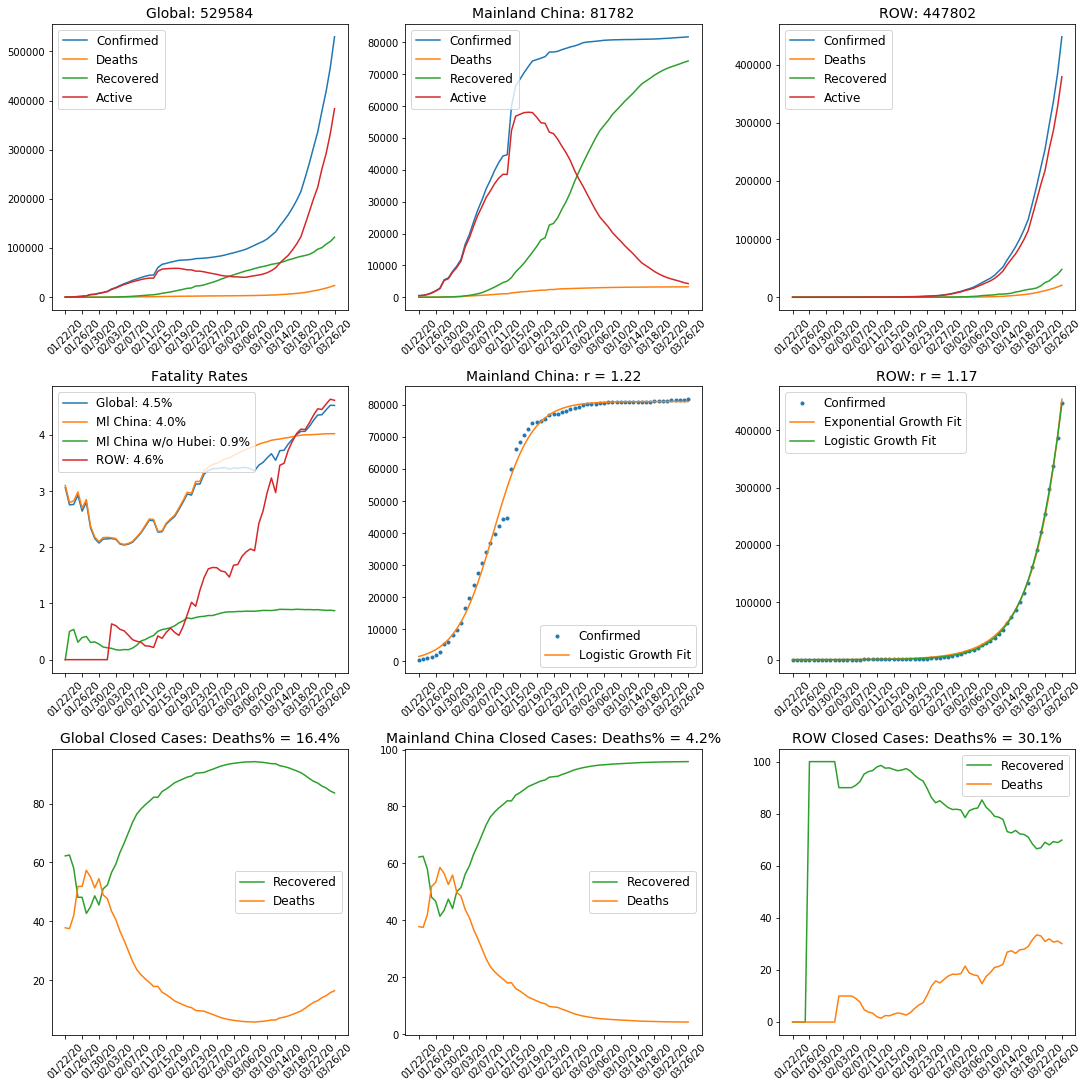

In [19]:
fig = plt.figure(figsize = (15, 15), constrained_layout=True, facecolor="1")
gs = fig.add_gridspec(3,3)

title_size = 14
legend_size = 12

### total confirmed/recovered/death/active
ax1 = fig.add_subplot(gs[0, 0])
ax1.plot(df_total[cat_cols])
# ax11, ax12 = two_scales(ax1, df_total[['Confirmed', 'Active']], df_total[['Recovered', 'Deaths']], cat_color)
myLocator = mticker.MultipleLocator(4)
ax1.xaxis.set_major_locator(myLocator)
ax1.tick_params(axis = 'x', labelrotation = 45)
ax1.legend(cat_cols, fontsize = legend_size)
ax1.set_title(f"Global: {int(df_total.loc[time_str[-1], 'Confirmed'])}", size = title_size)

### mainland china confirmed/recovered/death/active
ax2 = fig.add_subplot(gs[0, 1])
ax2.plot(df_mc[cat_cols])
myLocator = mticker.MultipleLocator(4)
ax2.xaxis.set_major_locator(myLocator)
ax2.tick_params(axis = 'x', labelrotation = 45)
ax2.legend(cat_cols, fontsize = legend_size)
ax2.set_title(f'Mainland China: {int(df_mc.loc[time_str[-1], "Confirmed"])}', size = title_size)

### rest of the world confirmed/recovered/death/active
ax3 = fig.add_subplot(gs[0, 2])
ax3.plot(df_row[cat_cols])
# ax31, ax32 = two_scales(ax3, df_row[['Confirmed', 'Active']], df_row[['Recovered', 'Deaths']], cat_color, legend_size)
myLocator = mticker.MultipleLocator(4)
ax3.xaxis.set_major_locator(myLocator)
ax3.tick_params(axis = 'x', labelrotation = 45)
ax3.legend(cat_cols, fontsize = legend_size)
ax3.set_title(f'ROW: {int(df_row.loc[time_str[-1], "Confirmed"])}', size = title_size)

### fatality rates
ax4 = fig.add_subplot(gs[1, 0])
ax4.plot(df_total.loc[:,'Fatality_rate'])
ax4.plot(df_mc.loc[:,'Fatality_rate'])
ax4.plot(df_co.loc[:,'Fatality_rate'])
ax4.plot(df_row.loc[:,'Fatality_rate'])
plt.legend([f'Global: {df_total.Fatality_rate[-1]:.1f}%',
            f'Ml China: {df_mc.Fatality_rate[-1]:.1f}%',
            f'Ml China w/o Hubei: {df_co.Fatality_rate[-1]:.1f}%',
            f'ROW: {df_row.Fatality_rate[-1]:.1f}%'
           ], fontsize = legend_size)
myLocator = mticker.MultipleLocator(4)
ax4.xaxis.set_major_locator(myLocator)
ax4.tick_params(axis = 'x', labelrotation = 45)
ax4.set_title('Fatality Rates', fontsize = title_size)

### mainland China fit
ax5 = fig.add_subplot(gs[1, 1])
ax5.plot(x, y[:,0], '.')
ax5.plot(x, logistic_growth(x, popt_log[0][0], popt_log[0][1], popt_log[0][2]))
ax5.xaxis.set_major_formatter(mticker.FuncFormatter(format_fn))
myLocator = mticker.MultipleLocator(4)
ax5.xaxis.set_major_locator(myLocator)
ax5.tick_params(axis = 'x', labelrotation = 45)
ax5.legend(['Confirmed', 'Logistic Growth Fit'], fontsize = legend_size)
ax5.set_title(f'Mainland China: r = {popt_log[0][0]+1:.2f}', fontsize = title_size)

### ROW fit
ax6 = fig.add_subplot(gs[1, 2])
ax6.plot(x, y[:,1], '.')
ax6.plot(x, exp_growth(x, popt_exp[1][0], popt_exp[1][1]))
ax6.plot(x, logistic_growth(x, popt_log[1][0], popt_log[1][1], popt_log[1][2]))
ax6.xaxis.set_major_formatter(mticker.FuncFormatter(format_fn))
myLocator = mticker.MultipleLocator(4)
ax6.xaxis.set_major_locator(myLocator)
ax6.tick_params(axis = 'x', labelrotation = 45)
ax6.legend(['Confirmed', 'Exponential Growth Fit', 'Logistic Growth Fit'], fontsize = legend_size)
ax6.set_title(f'ROW: r = {popt_log[1][0]+1:.2f}', fontsize = title_size)
              
### total closed cases
ax7 = fig.add_subplot(gs[2, 0])
ax7.plot(df_total.Recovered_prop, color = cat_color['Recovered'])
ax7.plot(df_total.Death_prop, color = cat_color['Deaths'])
myLocator = mticker.MultipleLocator(4)
ax7.xaxis.set_major_locator(myLocator)
ax7.tick_params(axis = 'x', labelrotation = 45)
ax7.legend(['Recovered', 'Deaths'], fontsize = legend_size)
ax7.set_title(f'Global Closed Cases: Deaths% = {df_total.Death_prop[-1]:.1f}%', size = title_size)

### mainland china closed cases
ax8 = fig.add_subplot(gs[2, 1])
ax8.plot(df_mc.Recovered_prop, color = cat_color['Recovered'])
ax8.plot(df_mc.Death_prop, color = cat_color['Deaths'])
myLocator = mticker.MultipleLocator(4)
ax8.xaxis.set_major_locator(myLocator)
ax8.tick_params(axis = 'x', labelrotation = 45)
ax8.legend(['Recovered', 'Deaths'], fontsize = legend_size)
ax8.set_title(f'Mainland China Closed Cases: Deaths% = {df_mc.Death_prop[-1]:.1f}%', size = title_size)

### rest of the world closed cases
ax9 = fig.add_subplot(gs[2, 2])
ax9.plot(df_row.Recovered_prop, color = cat_color['Recovered'])
ax9.plot(df_row.Death_prop, color = cat_color['Deaths'])
myLocator = mticker.MultipleLocator(4)
ax9.xaxis.set_major_locator(myLocator)
ax9.tick_params(axis = 'x', labelrotation = 45)
ax9.legend(['Recovered', 'Deaths'], fontsize = legend_size)
_ = ax9.set_title(f'ROW Closed Cases: Deaths% = {df_row.Death_prop[-1]:.1f}%', size = title_size)

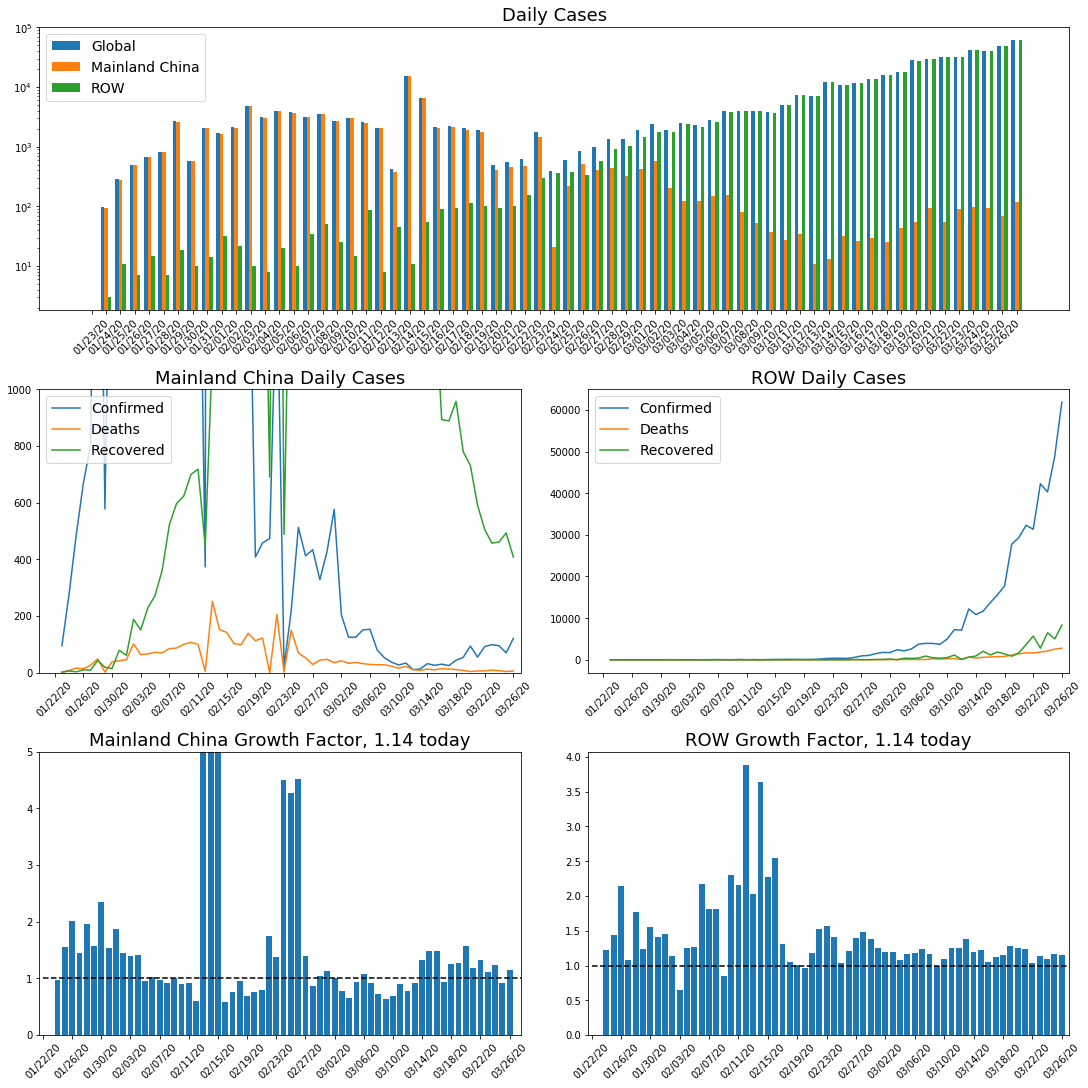

In [20]:
fig = plt.figure(figsize = (15, 15), constrained_layout=True, facecolor="1")
gs = fig.add_gridspec(3,2)

# ### Daily Confirmed cases
ax1 = fig.add_subplot(gs[0, :])
x = np.arange(len(time_str))
width = 0.25

ax1.bar(x + 0, df_total.loc[:,'Daily'], width = width)
ax1.bar(x + width*1, df_mc.loc[:,'Daily'], width = width)
ax1.bar(x + width*2, df_row.loc[:,'Daily'], width = width)
ax1.set_yscale('log')
# ax4.set_ylim([0, 5000])
_ = ax1.set_xticks(x + width)
_ = ax1.set_xticklabels(time_str[1:])
ax1.tick_params(axis = 'x', labelrotation = 45)
ax1.legend(['Global', 'Mainland China', 'ROW'], fontsize = 14, loc='upper left')
ax1.set_title('Daily Cases', size = 18)


### Mainland China daily confirmed/recovered/deaths/active
ax2 = fig.add_subplot(gs[1, 0])
ax2.plot(df_mc[cat_cols[:-1]].diff())
ax2.xaxis.set_major_formatter(mticker.FuncFormatter(format_fn))
myLocator = mticker.MultipleLocator(4)
ax2.xaxis.set_major_locator(myLocator)
ax2.set_ylim([0, 1000])
ax2.set_xlim(right = len(time_str))
ax2.tick_params(axis = 'x', labelrotation = 45)
ax2.legend(cat_cols, fontsize = 14)
ax2.set_title('Mainland China Daily Cases', size = 18)

### ROW daily confirmed/recovered/deaths/active
ax3 = fig.add_subplot(gs[1, 1])
ax3.plot(df_row[cat_cols[:-1]].diff())
ax3.xaxis.set_major_formatter(mticker.FuncFormatter(format_fn))
myLocator = mticker.MultipleLocator(4)
ax3.xaxis.set_major_locator(myLocator)
ax3.set_xlim(right = len(time_str))
ax3.tick_params(axis = 'x', labelrotation = 45)
ax3.legend(cat_cols, fontsize = 14)
ax3.set_title('ROW Daily Cases', size = 18)


# ### Mainland China Growth Factor
ax5 = fig.add_subplot(gs[2, 0])

x = np.arange(0, len(time_str))
x1 = np.arange(0, len(time_str) + 2)

ax5.bar(x, df_mc.GF_rolling)
ax5.plot(x1, np.full(len(x1), 1), '--', color = 'k')
ax5.xaxis.set_major_formatter(mticker.FuncFormatter(format_fn))
myLocator = mticker.MultipleLocator(4)
ax5.xaxis.set_major_locator(myLocator)
ax5.set_xlim([-0.5, len(time_str)+0.5])
ax5.set_ylim(top = 5, bottom = 0)
ax5.tick_params(axis = 'x', labelrotation = 45)
ax5.set_title(f'Mainland China Growth Factor, {df_mc.GF_rolling[-1]:.2f} today', size = 18)

### ROW Growth Factor
ax6 = fig.add_subplot(gs[2, 1])
ax6.bar(x, df_row.GF_rolling)
ax6.plot(x1, np.full(len(x1), 1), '--', color = 'k')
ax6.xaxis.set_major_formatter(mticker.FuncFormatter(format_fn))
myLocator = mticker.MultipleLocator(4)
ax6.xaxis.set_major_locator(myLocator)
ax6.set_xlim([-0.5, len(time_str)])
ax6.tick_params(axis = 'x', labelrotation = 45)
_ = ax6.set_title(f'ROW Growth Factor, {df_row.GF_rolling[-1]:.2f} today', size = 18)

In [21]:
"""US"""

'US'

In [22]:
state = 'California'

df_US = df_time_series.groupby(['Country_Region']).get_group(('US'))
df_CA = df_US.groupby(['Province_State']).get_group(state)
df_DP = pd.DataFrame()
df_USmain = pd.DataFrame()
df_GP = pd.DataFrame()

for i in df_US.index:
    if('Diamond Princess'in df_US.loc[i, 'Province_State']) :
        df_DP = df_DP.append(df_US.loc[i,:])
    if('Grand Princess' in df_US.loc[i, 'Province_State']):
        df_GP = df_GP.append(df_US.loc[i,:])
    else:
        df_USmain = df_USmain.append(df_US.loc[i,:])
df_US_ori = df_US

In [23]:
df_US = reshape_dataframe(df_US.groupby('Category').sum().loc[:,time_str], time_str)
df_CA = reshape_dataframe(df_CA.groupby('Category').sum().loc[:,time_str], time_str)
df_USmain = reshape_dataframe(df_USmain.groupby('Category').sum().loc[:,time_str], time_str)
df_DP = reshape_dataframe(df_DP.groupby('Category').sum().loc[:,time_str], time_str)
df_GP = reshape_dataframe(df_GP.groupby('Category').sum().loc[:,time_str], time_str)

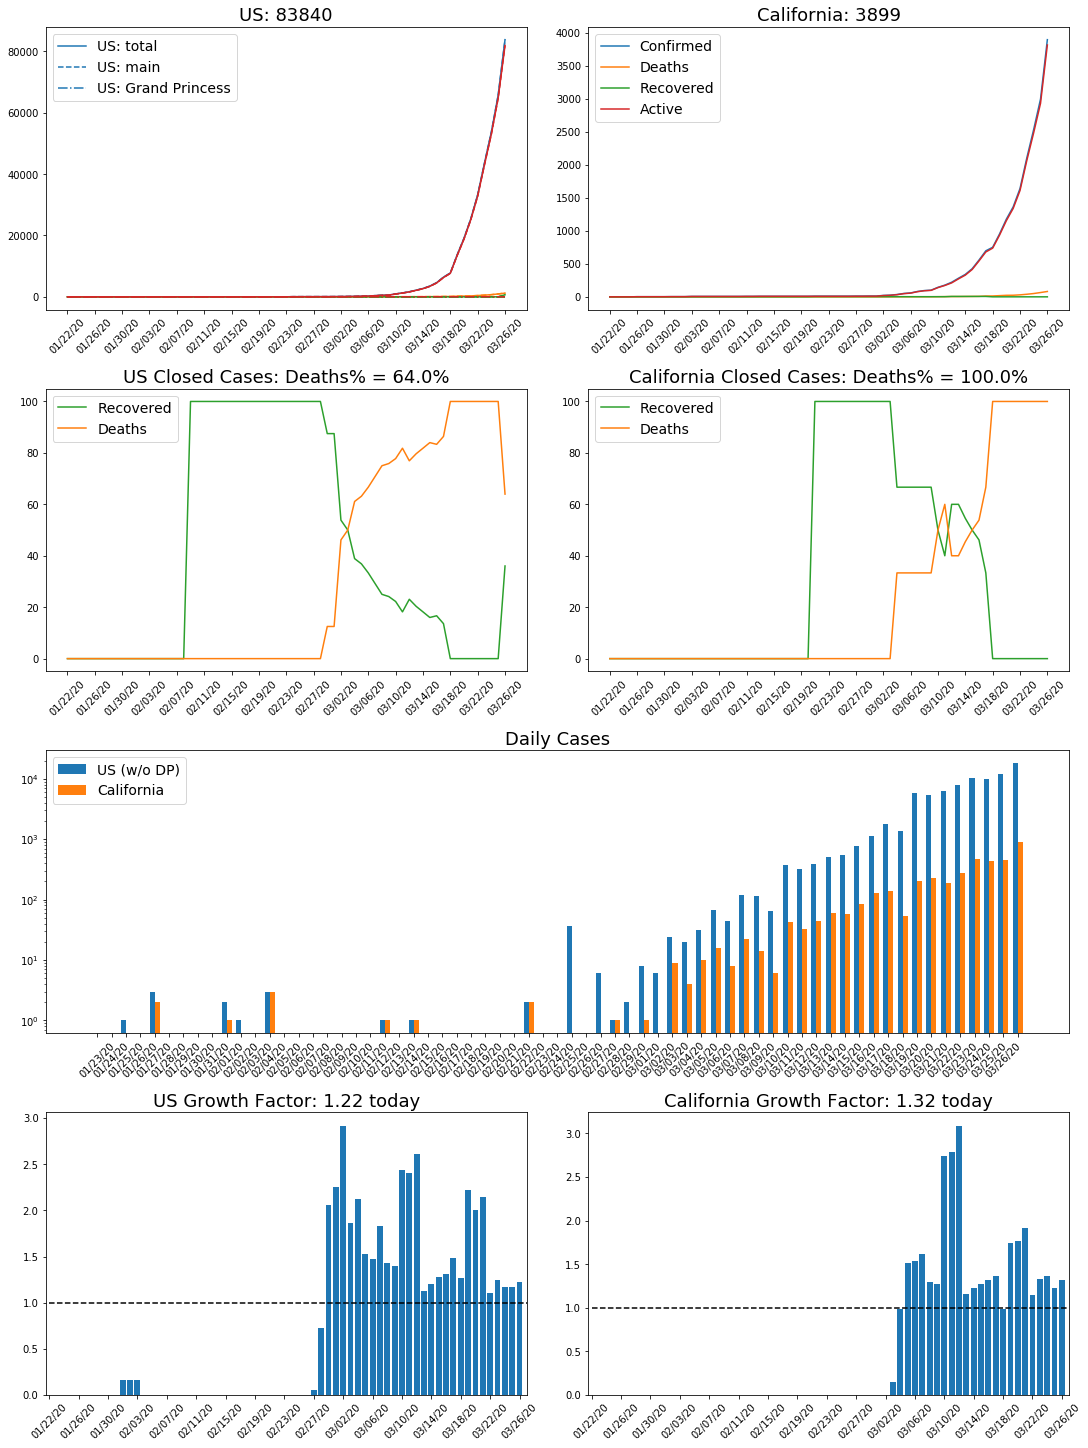

In [24]:
fig = plt.figure(figsize = (15, 20), constrained_layout=True, facecolor="1")
gs = fig.add_gridspec(4,2)

### US confirmed/recovered/deaths/active
ax1 = fig.add_subplot(gs[0, 0])
for cat in cat_color:
    ax1.plot(df_US.loc[:,cat], color = cat_color[cat])
    ax1.plot(df_USmain.loc[:,cat], '--', color = cat_color[cat])
    ax1.plot(df_GP.loc[:,cat], '-.', color = cat_color[cat])
legend = ['US: total', 'US: main', 'US: Grand Princess']
myLocator = mticker.MultipleLocator(4)
ax1.xaxis.set_major_locator(myLocator)
ax1.tick_params(axis = 'x', labelrotation = 45)
ax1.legend(legend, fontsize = 14)
ax1.set_title(f'US: {int(df_US.loc[time_str[-1], "Confirmed"])}', size = 18)

              
### state confirmed/recovered/deaths/active
ax2 = fig.add_subplot(gs[0, 1])
ax2.plot(df_CA[cat_cols])
myLocator = mticker.MultipleLocator(4)
ax2.xaxis.set_major_locator(myLocator)
ax2.tick_params(axis = 'x', labelrotation = 45)
ax2.legend(cat_cols, fontsize = 14)
ax2.set_title(f'{state}: {int(df_CA.loc[time_str[-1], "Confirmed"])}', size = 18)

### US Closed cases      
ax8 = fig.add_subplot(gs[1, 0])
ax8.plot(df_US.Recovered_prop, color = cat_color['Recovered'])
ax8.plot(df_US.Death_prop, color = cat_color['Deaths'])
myLocator = mticker.MultipleLocator(4)
ax8.xaxis.set_major_locator(myLocator)
ax8.tick_params(axis = 'x', labelrotation = 45)
ax8.legend(['Recovered', 'Deaths'], fontsize = 14)
ax8.set_title(f'US Closed Cases: Deaths% = {df_US.Death_prop[-1]:.1f}%', size = 18)

### state Closed cases
ax9 = fig.add_subplot(gs[1, 1])
ax9.plot(df_CA.Recovered_prop, color = cat_color['Recovered'])
ax9.plot(df_CA.Death_prop, color = cat_color['Deaths'])
ax9.xaxis.set_major_locator(myLocator)
ax9.tick_params(axis = 'x', labelrotation = 45)
ax9.legend(['Recovered', 'Deaths'], fontsize = 14)
ax9.set_title(f'{state} Closed Cases: Deaths% = {df_CA.Death_prop[-1]:.1f}%', size = 18)
              
### Daily new cases              
ax3 = fig.add_subplot(gs[2, :])
x = np.arange(len(time_str))
width = 0.35
rects1 = ax3.bar(x - width/2, df_USmain.loc[:,'Daily'], width = width)
rects2 = ax3.bar(x + width/2, df_CA.loc[:,'Daily'], width = width)
ax3.set_yscale('log')
# ax3.set_yscale('linear')
# ax3.set_ylim([0, 1000])
_ = ax3.set_xticks(x)
_ = ax3.set_xticklabels(time_str[1:])
ax3.tick_params(axis = 'x', labelrotation = 45)
ax3.legend(['US (w/o DP)', state], fontsize = 14)
ax3.set_title('Daily Cases', size = 18)

              
### US growth factors
ax4 = fig.add_subplot(gs[3, 0])
              
x = np.arange(len(time_str))
x1 = np.arange(0, len(time_str) + 2)
              
ax4.bar(x, df_USmain.GF_rolling)
ax4.plot(x1, np.full(len(x1), 1), '--', color = 'k')
ax4.xaxis.set_major_formatter(mticker.FuncFormatter(format_fn))
myLocator = mticker.MultipleLocator(4)
ax4.xaxis.set_major_locator(myLocator)
ax4.set_xlim([-0.5, len(time_str)])
ax4.tick_params(axis = 'x', labelrotation = 45)
_ = ax4.set_title(f'US Growth Factor: {df_USmain.GF_rolling[-1]:.2f} today', size = 18)

              
### state growth factors
ax5 = fig.add_subplot(gs[3, 1])
              
ax5.bar(x, df_CA.GF_rolling)
ax5.plot(x1, np.full(len(x1), 1), '--', color = 'k')
ax5.xaxis.set_major_formatter(mticker.FuncFormatter(format_fn))
myLocator = mticker.MultipleLocator(4)
ax5.xaxis.set_major_locator(myLocator)
ax5.set_xlim([-0.5, len(time_str)])
ax5.tick_params(axis = 'x', labelrotation = 45)
_ = ax5.set_title(f'{state} Growth Factor: {df_CA.GF_rolling[-1]:.2f} today', size = 18)

In [25]:
ys = np.zeros((len(time_str), 4))
x = np.arange(len(time_str))

ys[:,0] = df_US.loc[time_str, 'Confirmed'].to_numpy()
ys[:,1] = df_US_1p3a.loc[time_str, 'US'].to_numpy()
ys[:,2] = df_CA.loc[time_str, 'Confirmed'].to_numpy()
ys[:,3] = df_US_1p3a.loc[time_str, 'CA'].to_numpy()
d1 = df_US.loc[time_str, 'Deaths'].to_numpy()
d2 = df_CA.loc[time_str, 'Deaths'].to_numpy()

res1 = df_US[df_US.GF_rolling_thr != 0.0].bfill(axis=1).index[0]
res2 = df_CA[df_CA.GF_rolling_thr != 0.0].bfill(axis=1).index[0]

ind1_t0 = max(0, time_str.index(res1)-3)
ind2_t0 = max(0, time_str.index(res2)-3)

t1 = np.arange(len(time_str))[ind1_t0:]- ind1_t0
t2 = np.arange(len(time_str))[ind2_t0:]- ind2_t0

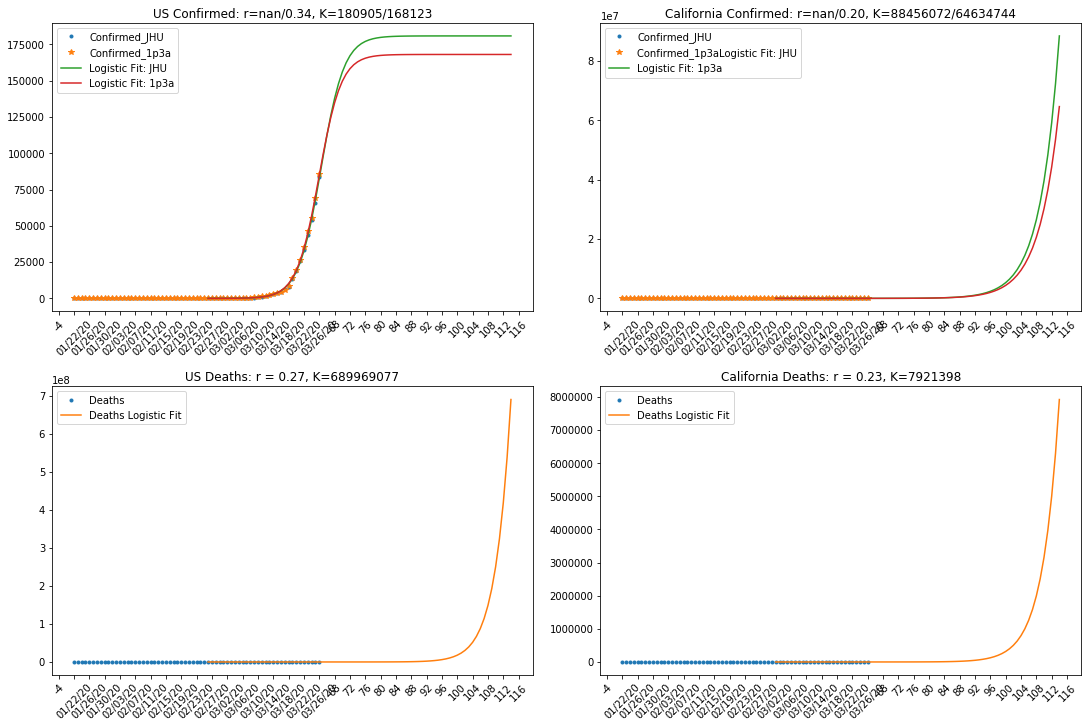

In [26]:
future = 50
yscale = 'linear'


fig = plt.figure(figsize = (15, 10), constrained_layout=True, facecolor="1")
gs = fig.add_gridspec(2, 2)

### US: confirmed
ax1 = fig.add_subplot(gs[0, 0])

x1 = np.arange((len(t1) + future))
ax1.plot(x, ys[:,0], '.')
ax1.plot(x, ys[:,1], '*')
if(future == 0):
    r_exp = 0
    for i in [0,1]:
        popt, pcov = opt.curve_fit(exp_growth, t1, ys[ind1_t0:,i], maxfev = 10000)
        ax1.plot(x1 + ind1_t0, exp_growth(x1, popt[0], popt[1]))
        r_exp += popt[0]
    r_exp = r_exp/2
else:
    r_exp = np.nan
r_log = 0
k_log = []
for i in [0,1]:
    popt, pcov = opt.curve_fit(logistic_growth, t1, ys[ind1_t0:,i], maxfev = 10000)
    ax1.plot(x1 + ind1_t0, logistic_growth(x1, popt[0], popt[1], popt[2]))
    r_log += popt[0]
    k_log.append(logistic_growth(x1, popt[0], popt[1], popt[2])[-1])
r_log = r_log/2
ax1.xaxis.set_major_formatter(mticker.FuncFormatter(format_fn))
myLocator = mticker.MultipleLocator(4)
ax1.xaxis.set_major_locator(myLocator)
ax1.set_yscale(yscale)
# ax1.set_ylim([0, 3*10**11])
ax1.tick_params(axis = 'x', labelrotation = 45)
if(future == 0):
    ax1.legend(['Confirmed_JHU', 
                'Confirmed_1p3a',
                'Exponential Fit: JHU',
                'Exponential Fit: 1p3a',
                'Logistic Fit: JHU', 
                'Logistic Fit: 1p3a'])
    ax1.set_title(f'US Confirmed: growth rate {r_exp:.2f}/{r_log:.2f}')
else:
    ax1.legend(['Confirmed_JHU', 
                'Confirmed_1p3a',
                'Logistic Fit: JHU', 
                'Logistic Fit: 1p3a'])
    ax1.set_title(f'US Confirmed: r={r_exp:.2f}/{r_log:.2f}, K={k_log[0]:.0f}/{k_log[1]:.0f}')


## State: Confirmed
ax2 = fig.add_subplot(gs[0, 1])

x1 = np.arange((len(t2) + future))
ax2.plot(x, ys[:,2], '.')
if(state == 'California'):
    ax2.plot(x, ys[:,3], '*')
if(future == 0):
    r_exp = 0
    if(state == 'California'):
        for i in [2,3]:
            popt, pcov = opt.curve_fit(exp_growth, t2, ys[ind2_t0:,i], maxfev = 10000)
            ax2.plot(x1 + ind2_t0, exp_growth(x1, popt[0], popt[1]))
            r_exp += popt[0]
        r_exp = r_exp/2
    else:
        i = 2
        popt, pcov = opt.curve_fit(exp_growth, t2, ys[ind2_t0:,i], maxfev = 10000)
        ax2.plot(x1 + ind2_t0, exp_growth(x1, popt[0], popt[1]))
        r_exp = popt[0]
else:
        r_exp = np.nan
r_log = 0
k_log = []
if(state == 'California'):
    for i in [2,3]:
        popt, pcov = opt.curve_fit(logistic_growth, t2, ys[ind2_t0:,i], p0 = [0.1, 100, 1], maxfev = 10000)
        ax2.plot(x1 + ind2_t0, logistic_growth(x1, popt[0], popt[1], popt[2]))
        r_log += popt[0]
        k_log.append(logistic_growth(x1, popt[0], popt[1], popt[2])[-1])
    r_log = r_log/2
else:
    i = 2
    popt, pcov = opt.curve_fit(logistic_growth, t2, ys[ind2_t0:,i], p0 = [0.1, 100, 1], maxfev = 10000)
    ax2.plot(x1 + ind2_t0, logistic_growth(x1, popt[0], popt[1], popt[2]))
    r_log = popt[0]
    k_log = logistic_growth(x1, popt[0], popt[1], popt[2])[-1]
ax2.xaxis.set_major_formatter(mticker.FuncFormatter(format_fn))
myLocator = mticker.MultipleLocator(4)
ax2.xaxis.set_major_locator(myLocator)
ax2.set_yscale(yscale)
# ax.set_ylim([0, 60000])
ax2.tick_params(axis = 'x', labelrotation = 45)
if(future == 0):
    if(state == 'California'):
        ax2.legend(['Confirmed_JHU', 
                    'Confirmed_1p3a',
                    'Exponential Fit: JHU',
                    'Exponential Fit: 1p3a',
                    'Logistic Fit: JHU', 
                    'Logistic Fit: 1p3a'])
    else:
        ax2.legend(['Confirmed_JHU', 
                    'Exponential Fit: JHU',
                    'Logistic Fit: JHU'])
    ax2.set_title(f'{state} Confirmed: growth rate {r_exp:.2f}/{r_log:.2f}')
else:
    if(state == 'California'):
        ax2.legend(['Confirmed_JHU',
                    'Confirmed_1p3a'
                    'Logistic Fit: JHU', 
                    'Logistic Fit: 1p3a'])
        ax2.set_title(f'{state} Confirmed: r={r_exp:.2f}/{r_log:.2f}, K={k_log[0]:.0f}/{k_log[1]:.0f}')
    else:
        ax2.legend(['Confirmed_JHU',
                    'Logistic Fit: JHU'])
        ax2.set_title(f'{state} Confirmed: r={r_exp:.2f}/{r_log:.2f}, K={k_log:.0f}')


### US: deaths
ax3 = fig.add_subplot(gs[1, 0])

x1 = np.arange((len(t1) + future))
ax3.plot(x, d1, '.')
if(future == 0):
    popt, pcov = opt.curve_fit(exp_growth, t1, d1[ind1_t0:], maxfev = 10000)
    ax3.plot(x1 + ind1_t0, exp_growth(x1, popt[0], popt[1]))
popt, pcov = opt.curve_fit(logistic_growth, t1, d1[ind1_t0:], p0 = [0.1, 100, 1], maxfev = 10000)
ax3.plot(x1 + ind1_t0, logistic_growth(x1, popt[0], popt[1], popt[2]))
k_log = logistic_growth(x1, popt[0], popt[1], popt[2])[-1]

ax3.xaxis.set_major_formatter(mticker.FuncFormatter(format_fn))
myLocator = mticker.MultipleLocator(4)
ax3.xaxis.set_major_locator(myLocator)
ax3.set_yscale(yscale)
ax3.tick_params(axis = 'x', labelrotation = 45)
if(future == 0):
    ax3.legend(['Deaths', 
                'Deaths Exponential Fit',
                'Deaths Logistic Fit'])
    ax3.set_title(f'US Deaths: r = {popt[0]:.2f}')
else:
    ax3.legend(['Deaths', 
                'Deaths Logistic Fit'])
    ax3.set_title(f'US Deaths: r = {popt[0]:.2f}, K={k_log:.0f}')

### State: deaths
ax4 = fig.add_subplot(gs[1, 1])

x1 = np.arange((len(t2) + future))
ax4.plot(x, d2, '.')
if(future == 0):
    popt, pcov = opt.curve_fit(exp_growth, t2, d2[ind2_t0:], maxfev = 10000)
    ax4.plot(x1 + ind2_t0, exp_growth(x1, popt[0], popt[1]))
popt, pcov = opt.curve_fit(logistic_growth, t2, d2[ind2_t0:], p0 = [0.1, 100, 1], maxfev = 10000)
ax4.plot(x1 + ind2_t0, logistic_growth(x1, popt[0], popt[1], popt[2]))
k_log = logistic_growth(x1, popt[0], popt[1], popt[2])[-1]

ax4.xaxis.set_major_formatter(mticker.FuncFormatter(format_fn))
myLocator = mticker.MultipleLocator(4)
ax4.xaxis.set_major_locator(myLocator)
ax4.set_yscale(yscale)
ax4.tick_params(axis = 'x', labelrotation = 45)
if(future == 0):
    ax4.legend(['Deaths', 
                'Deaths Exponential Fit',
                'Deaths Logistic Fit'])
    ax4.set_title(f'{state} Deaths: r = {popt[0]:.2f}')
else:
    ax4.legend(['Deaths', 
                'Deaths Logistic Fit'])
    ax4.set_title(f'{state} Deaths: r = {popt[0]:.2f}, K={k_log:.0f}')


In [27]:
"""US by states"""

'US by states'

In [28]:
df_us_confirmed = df_US_ori.groupby('Category').get_group('Confirmed').groupby('Province_State').sum()[time_str]
df_us_recovered = df_US_ori.groupby('Category').get_group('Recovered').groupby('Province_State').sum()[time_str]
df_us_deaths = df_US_ori.groupby('Category').get_group('Deaths').groupby('Province_State').sum()[time_str]
df_us_active = df_us_confirmed - (df_us_recovered + df_us_deaths)
df_us_confirmed['New_Today'] = df_us_confirmed[time_str[-1]] - df_us_confirmed[time_str[-2]]

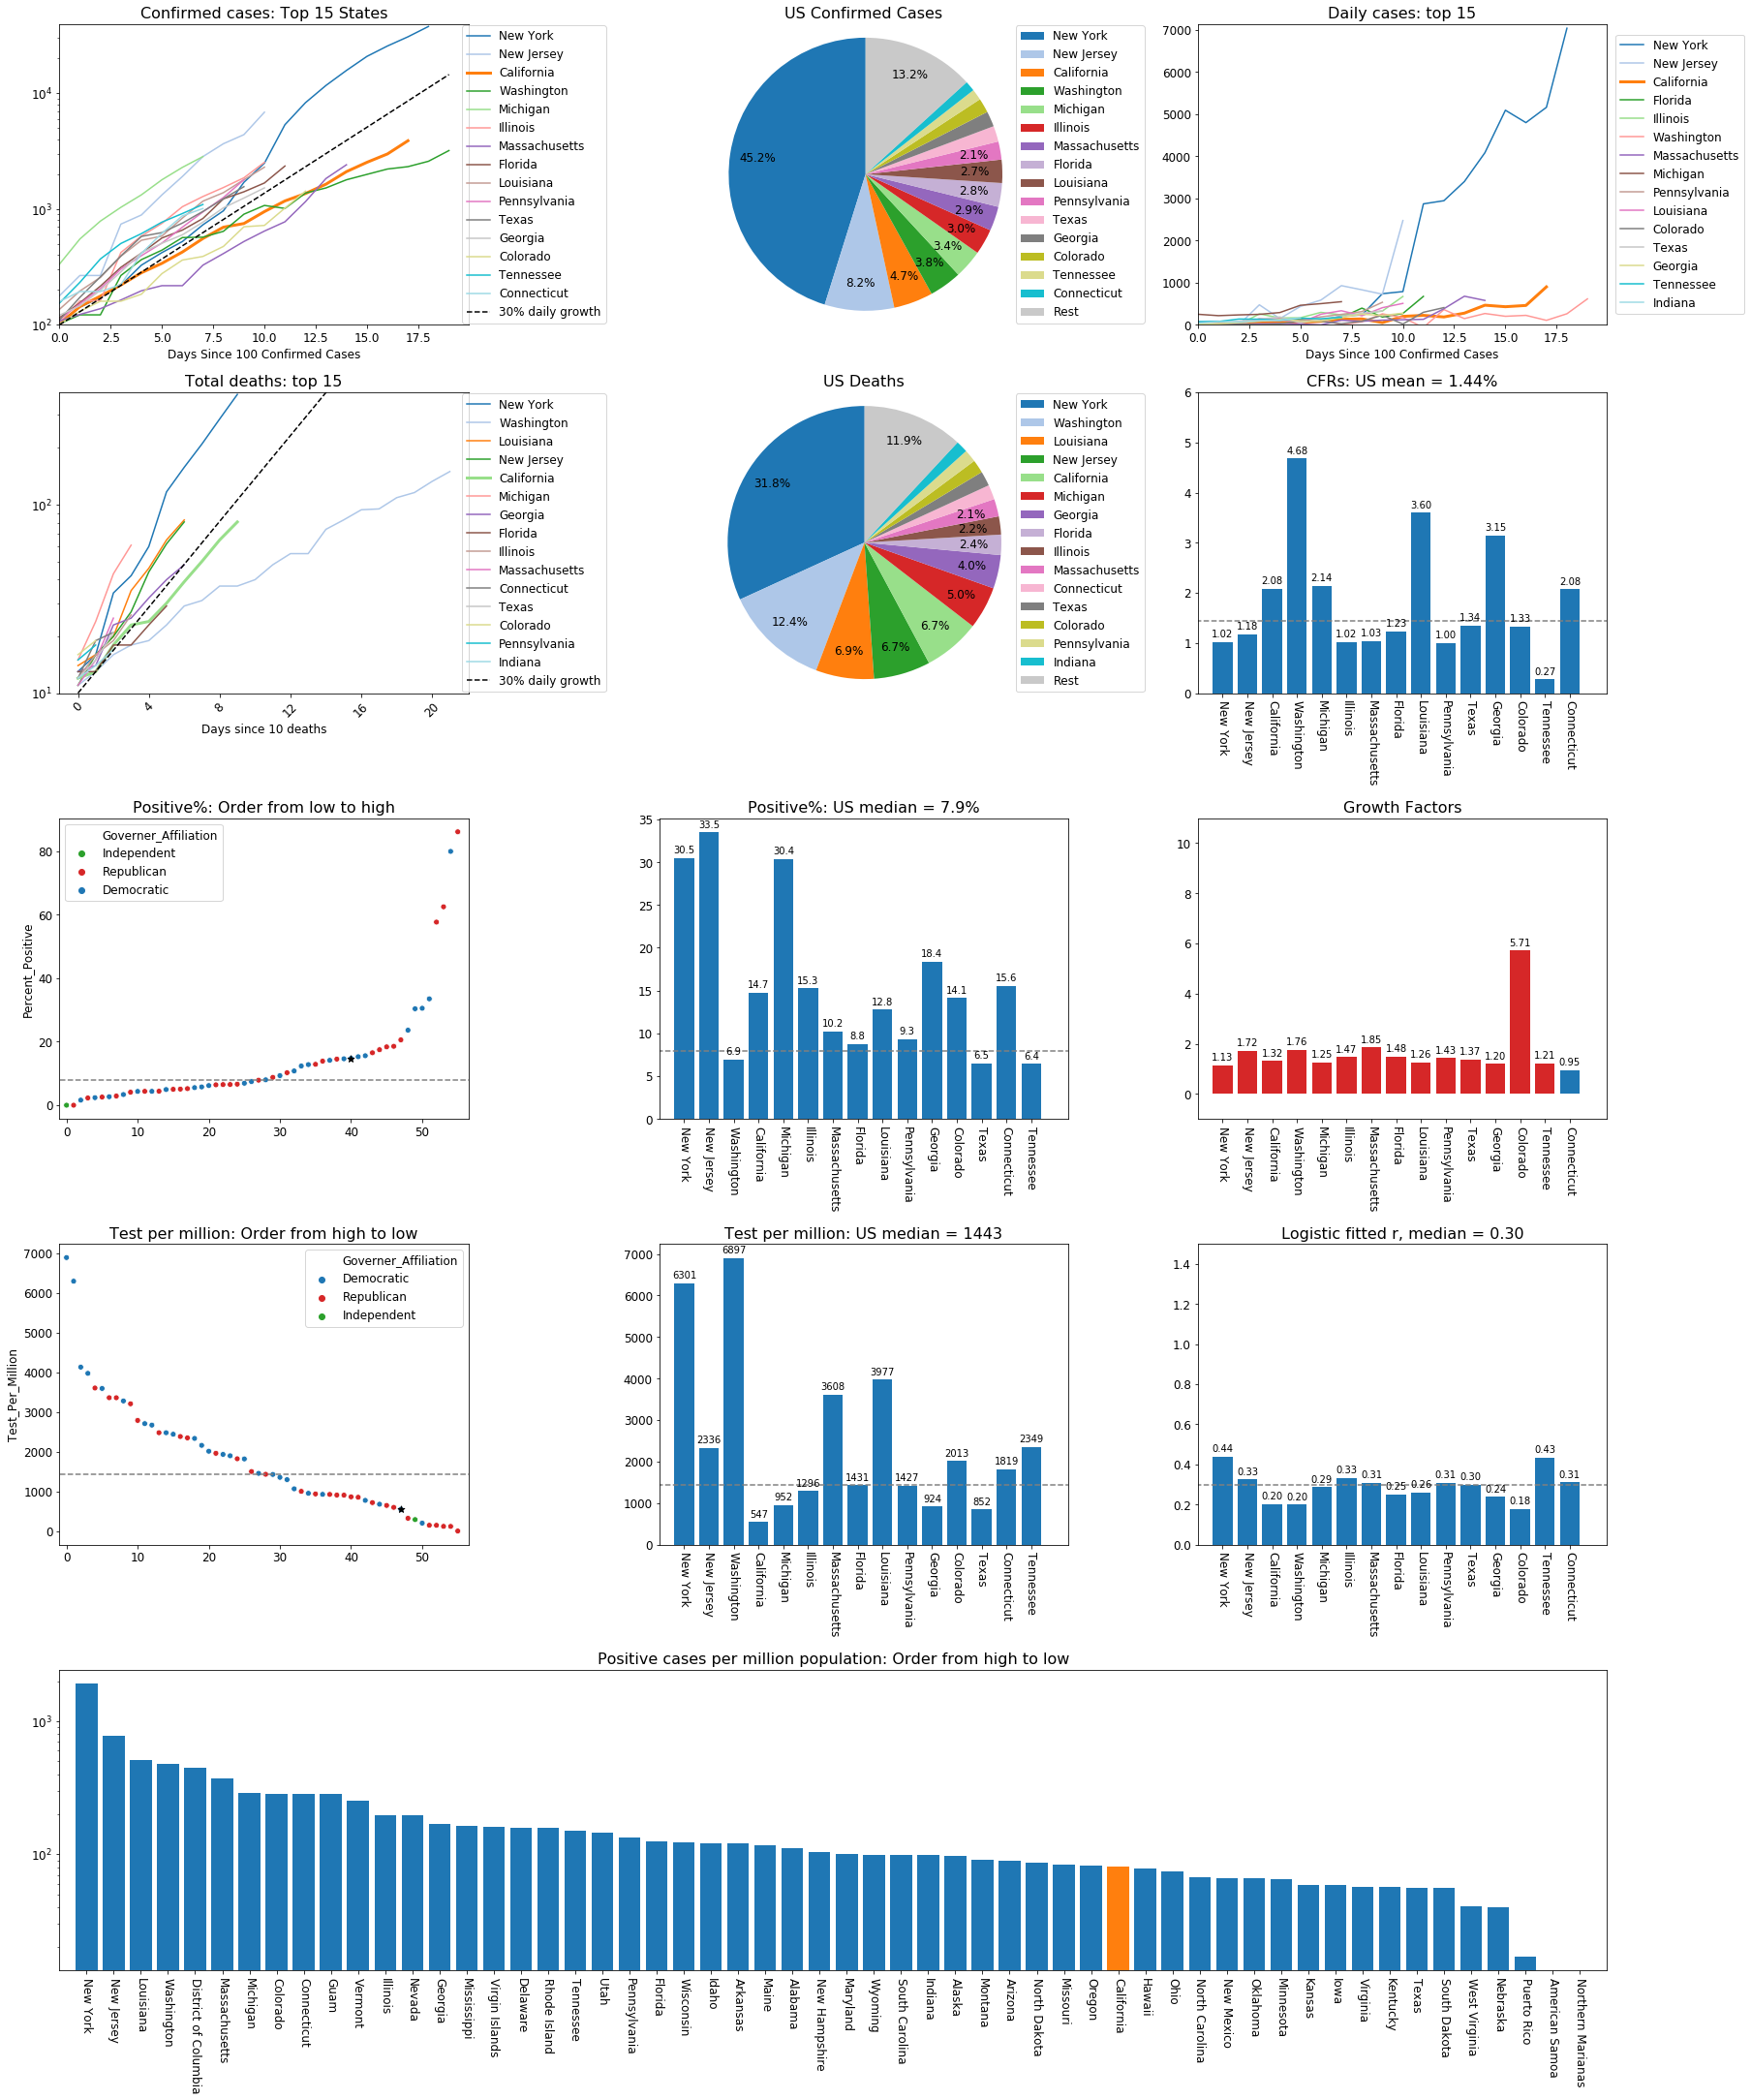

In [31]:
############ params ############
num_states = 15

############ figure ############
fig = plt.figure(figsize = (25, 30), constrained_layout=True, facecolor="1")
gs = fig.add_gridspec(5, 3)

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

ind_t0 = time_str.index(time_str[0])
time_plot = time_str[ind_t0:]


############ r for logistic growth fit ############
ax6 = fig.add_subplot(gs[3, 2])

df_us_confirmed.sort_values(by = time_str[-1], inplace = True, ascending=False)
states = list(df_us_confirmed.index[0:num_states])

x = np.arange(len(states))
x1 = np.arange(-2, len(x)+2)
y = []
for i in x:
    ctry = states[i]
    df_ctry = pd.DataFrame(df_us_confirmed.loc[ctry,time_plot])
    df_ctry = reshape_dataframe(df_ctry, time_plot)
    y.append(get_growth_rate(df_ctry, time_plot))
y = np.array(y)
r_median = np.median(y)

rects = ax6.bar(x, y)
ax6.plot(x1, np.full(len(x1), np.median(y)), '--', color = 'grey')
a = ax6.set_xticks(x)
a = ax6.set_xticklabels(states)
ax6.tick_params(axis = 'x', labelrotation = -90)
autolabel(rects, ax6, '{:.2f}')
# ymax = np.ceil(np.max(y)) + 0.5
ymax = 1.5
ax6.set_ylim([0, ymax])
ax6.set_xlim([-1, len(x) + 0.5])
a = ax6.set_title(f'Logistic fitted r, median = {np.median(y):.2f}')

############ total number normalized ############
ax2 = fig.add_subplot(gs[0, 0])

df_us_confirmed.sort_values(by = time_str[-1], inplace = True, ascending=False)
states = list(df_us_confirmed.index[0:num_states])
df_plot = df_us_confirmed.loc[states,time_plot]

colors = pl.cm.tab20(np.linspace(0,1,len(states)))
max_x = 0
for i, ctr in enumerate(states):
    xi = len(df_plot.loc[ctr, df_plot.loc[ctr,:]>100].to_numpy())
    if(ctr == 'California'):
        ax2.plot(df_plot.loc[ctr, df_plot.loc[ctr,:]>100].to_numpy(), color = colors[i], linewidth = 3)
    else:
        ax2.plot(df_plot.loc[ctr, df_plot.loc[ctr,:]>100].to_numpy(), color = colors[i])
    if(xi > max_x):
        max_x = xi
x = np.arange(max_x)
ax2.plot(x, 100 * (1 + r_median) ** x, ls='--', color='k')
ax2.legend(states + [f'{r_median*100:.0f}% daily growth'],
           loc="center right", bbox_to_anchor = (1, 0, 0.35, 1))
ax2.set_ylim(bottom = 100)
ax2.set_xlim(left = 0)
ax2.set_yscale('log')
ax2.set_xlabel('Days Since 100 Confirmed Cases')
ax2.set_title(f'Confirmed cases: Top {num_states} States')


############ total number pie chart ############
ax = fig.add_subplot(gs[0,1])

df_us_confirmed.sort_values(by = time_str[-1], inplace = True, ascending=False)
percentages = []
labels = []
us_confirmed_total = np.sum(df_us_confirmed.loc[:,time_str[-1]])
for state in df_us_confirmed.index[0:num_states]:
    percentages.append(df_us_confirmed.loc[state, time_str[-1]]/us_confirmed_total*100)
    labels.append(state)
labels.append('Rest')
percentages.append(100-sum(percentages))

colors = pl.cm.tab20(np.linspace(0,1,num_states+1))
colors[15,:] = 0.7
wedges, texts, autotexts = ax.pie(percentages, colors = colors, 
                                  autopct = my_autopct, pctdistance=0.8,
                                  shadow=False, startangle=90,
                                  textprops = dict(size = 12))

ax.legend(wedges, labels, loc="center right", bbox_to_anchor = (1, 0, 0.2, 1))
ax.axis('equal')
ax.set_title("US Confirmed Cases")


############ daily cases normalized ############
ax3 = fig.add_subplot(gs[0, 2])

df_us_confirmed.sort_values(by = 'New_Today', inplace = True, ascending=False)
states = list(df_us_confirmed.index[0:num_states])

colors = pl.cm.tab20(np.linspace(0,1,len(states)))
data_max = 0
for i, ctr in enumerate(states):
    yi = df_us_confirmed.loc[ctr,time_str].transpose().diff().loc[df_us_confirmed.loc[ctr,time_str]>100].to_numpy()
    xi = np.arange(len(yi))
    if(np.max(yi) > data_max):
        data_max = np.max(yi)
    if(ctr == 'California'):
        ax3.plot(xi, yi, color = colors[i], linewidth = 3)
    else:
        ax3.plot(xi, yi, color = colors[i])

ax3.legend(states, loc="center right", bbox_to_anchor = (1, 0, 0.35, 1))
ax3.set_yscale('linear')
a = ax3.set_title(f'Daily cases: top {num_states}')
ax3.set_ylim([0, data_max + 100])
ax3.set_xlim(left = 0)
ax3.set_xlabel('Days Since 100 Confirmed Cases')


############ total deaths ############
ax1 = fig.add_subplot(gs[1, 0])

df_us_deaths.sort_values(by = time_str[-1], inplace = True, ascending=False)
states = list(df_us_deaths.index[0:num_states])
df_plot = df_us_deaths.loc[states,time_str]

colors = pl.cm.tab20(np.linspace(0,1,len(states)))
max_x = 0
for i, ctr in enumerate(states):
    xi = len(df_plot.loc[ctr, df_plot.loc[ctr,:]>10].to_numpy())
    if(ctr == 'California'):
        ax1.plot(df_plot.loc[ctr, df_plot.loc[ctr,:]>10].to_numpy(), color = colors[i], linewidth = 3)
    else:
        ax1.plot(df_plot.loc[ctr, df_plot.loc[ctr,:]>10].to_numpy(), color = colors[i])
    if(xi > max_x):
        max_x = xi
x = np.arange(max_x)
max_y = np.max(df_plot.loc[states,:].to_numpy().flatten())

ax1.plot(x, 10 * (1 + 0.3) ** x, ls='--', color='k')

ax1.legend(states + ['30% daily growth'],
          loc="center right", bbox_to_anchor = (1, 0, 0.35, 1))
ax1.set_yscale('log')
ax1.set_xlabel('Days since 10 deaths')
ax1.set_ylim([10, max_y + 10])
# plt.ylim(top = 2000)
ax1.set_title(f'Total deaths: top {num_states}')
myLocator = mticker.MultipleLocator(4)
ax1.xaxis.set_major_locator(myLocator)
ax1.tick_params(axis = 'x', labelrotation = 45)


############ total deaths pie chart ############
ax = fig.add_subplot(gs[1,1])

df_us_deaths.sort_values(by = time_str[-1], inplace = True, ascending=False)
percentages = []
labels = []
us_deaths_total = np.sum(df_us_deaths.loc[:,time_str[-1]])
for state in df_us_deaths.index[0:num_states]:
    percentages.append(df_us_deaths.loc[state, time_str[-1]]/us_deaths_total*100)
    labels.append(state)
labels.append('Rest')
percentages.append(100-sum(percentages))

colors = pl.cm.tab20(np.linspace(0,1,num_states+1))
colors[15,:] = 0.7
wedges, texts, autotexts = ax.pie(percentages, colors = colors, 
                                  autopct = my_autopct, pctdistance=0.8,
                                  shadow=False, startangle=90,
                                  textprops = dict(size = 12))
ax.legend(wedges, labels, loc="center right", bbox_to_anchor = (1, 0, 0.2, 1))
ax.axis('equal')
ax.set_title("US Deaths")


############ fatality rate ############
ax5 = fig.add_subplot(gs[1, 2])

df_us_confirmed.sort_values(by = time_str[-1], inplace = True, ascending=False)
states = list(df_us_confirmed.index[0:num_states])

fatal_rates = df_us_deaths.loc[states,time_plot] / df_us_confirmed.loc[states,time_plot] * 100
x = np.arange(len(states))
x1 = np.arange(-2, len(x)+2)
fr_total = df_US.Fatality_rate[-1]

rects = ax5.bar(x, fatal_rates.loc[:,time_plot[-1]])
ax5.plot(x1, np.full(len(x1), fr_total), '--', color = 'grey')
a = ax5.set_xticks(x)
a = ax5.set_xticklabels(states)
ax5.tick_params(axis = 'x', labelrotation = -90)
autolabel(rects, ax5, '{:.2f}')
ymax = np.ceil(np.max(fatal_rates.loc[:,time_plot[-1]]) + 1)
ax5.set_ylim([0, ymax])
ax5.set_xlim([-1, len(x) + 0.5])
a = ax5.set_title(f'CFRs: US mean = {fr_total:.2f}%')


############ growth factors ############
ax4 = fig.add_subplot(gs[2, 2])

df_us_confirmed.sort_values(by = time_str[-1], inplace = True, ascending=False)
states = list(df_us_confirmed.index[0:num_states])

df_gf = df_us_confirmed.loc[states,time_plot].transpose()
for ctry in states:
    df_ctry = pd.DataFrame(df_us_confirmed.loc[ctry,time_plot])
    df_ctry = reshape_dataframe(df_ctry, time_plot)
    df_gf[ctry] = df_ctry.GF_rolling

x = np.arange(len(states))
y = df_gf.loc[time_plot[-1],:]

rects1 = ax4.bar(x[y<=1], y[y<=1], color = 'tab:blue')
rects2 = ax4.bar(x[y>1], y[y>1], color = 'tab:red')
a = ax4.set_xticks(x)
a = ax4.set_xticklabels(states)
ax4.tick_params(axis = 'x', labelrotation = -90)
autolabel(rects1, ax4, '{:.2f}')
autolabel(rects2, ax4, '{:.2f}')
ymax = np.ceil(np.max(y)) + 5
ax4.set_ylim([-1, ymax])
a = ax4.set_title('Growth Factors')
ax4.set_xlim([-1, len(x) + 0.5])

############ testing ############
### testing: positive rate v1
cat = 'Percent_Positive'
ax6 = fig.add_subplot(gs[2, 0])

df_plot = df_us_tests.sort_values(by = cat, inplace = False, ascending=True)
df_plot.reset_index(inplace = True, drop = True)
x = np.arange(len(df_plot.index))
y = df_plot.loc[x,cat].to_numpy()
x1 = np.arange(-2, len(df_plot.index) + 2)
ax6.set_xlim([-1, len(x) + 0.5])
i_ca = df_plot[df_plot.State == 'California'].index[0]

sns.scatterplot(x = x, y=cat, hue = 'Governer_Affiliation', palette = palette, data=df_plot, ax = ax6)
ax6.scatter(i_ca, df_plot.loc[i_ca, cat], marker = '*', s = 50, color = 'k')
ax6.plot(x1, np.full(len(x1), np.median(df_plot.loc[:,cat])), '--', color = 'grey')
a = ax6.set_title(f'Positive%: Order from low to high')

### testing: positive rate v2
ax8 = fig.add_subplot(gs[2, 1])

df_plot = df_us_tests.sort_values(by = 'positive', inplace = False, ascending=False)
df_plot.reset_index(inplace = True, drop = True)
states = list(df_plot.State[0:num_states])

x = np.arange(len(states))
x1 = np.arange(-2, len(states) + 2)
y = df_plot.loc[x,cat].to_numpy()

rects = ax8.bar(x, y)
ax8.plot(x1, np.full(len(x1), np.median(df_plot.loc[:,cat])), '--', color = 'grey')
ax8.tick_params(axis = 'x', labelrotation = -90)
autolabel(rects, ax8, '{:.1f}')
ax8.set_xlim([-1, len(x) + 0.5])
ax8.set_xticks(x)
ax8.set_xticklabels(states)
a = ax8.set_title(f'Positive%: US median = {np.median(df_plot.loc[:,cat]):.1f}%')


### testing: test per million v1
ax7 = fig.add_subplot(gs[3, 0])
cat = 'Test_Per_Million'

df_plot = df_us_tests.sort_values(by = cat, inplace = False, ascending=False)
states = list(df_us_tests.index[0:num_states])

df_plot.reset_index(inplace = True, drop = True)
x = np.arange(len(df_plot.index))
y = df_plot.loc[x,cat].to_numpy()
x1 = np.arange(-2, len(df_plot.index) + 2)
i_ca = df_plot[df_plot.State == 'California'].index[0]

sns.scatterplot(x = x, y=cat, hue = 'Governer_Affiliation', palette = palette, data=df_plot, ax = ax7)
ax7.scatter(i_ca, df_plot.loc[i_ca, cat], marker = '*', s = 50, color = 'k')
ax7.plot(x1, np.full(len(x1), np.median(df_plot.loc[:,cat])), '--', color = 'grey')
a = ax7.set_title(f'Test per million: Order from high to low')
ax7.set_xlim([-1, len(x) + 0.5])

### testing: test per million v2
ax9 = fig.add_subplot(gs[3, 1])

df_plot = df_us_tests.sort_values(by = 'positive', inplace = False, ascending=False)
df_plot.reset_index(inplace = True, drop = True)
states = list(df_plot.State[0:num_states])

x = np.arange(len(states))
x1 = np.arange(-2, len(states) + 2)
y = df_plot.loc[x,cat].to_numpy()

rects = ax9.bar(x, y)
ax9.plot(x1, np.full(len(x1), np.median(df_plot.loc[:,cat])), '--', color = 'grey')
a = ax9.set_xticks(x)
a = ax9.set_xticklabels(states)
ax9.tick_params(axis = 'x', labelrotation = -90)
autolabel(rects, ax9, '{:.0f}')
# ax8.set_ylim([0, ymax])
ax9.set_xlim([-1, len(x) + 0.5])
a = ax9.set_title(f'Test per million: US median = {np.median(df_plot.loc[:,cat]):.0f}')

### testing: Severeness index
ax10 = fig.add_subplot(gs[4, :])
cat = 'Pos_Per_Million'

df_plot = df_us_tests.sort_values(by = cat, inplace = False, ascending=False)
df_plot.reset_index(inplace = True, drop = True)

x = np.arange(len(df_plot.index))
y = df_plot.loc[x,cat].to_numpy()
i_ca = df_plot[df_plot.State == 'California'].index[0]

ax10.bar(x, y, color = 'tab:blue')
ax10.bar(i_ca, y[i_ca], color = 'tab:orange')
ax10.tick_params(axis = 'x', labelrotation = -90)
a = ax10.set_xticks(x)
a = ax10.set_xticklabels(list(df_plot.State))
a = ax10.set_title(f'Positive cases per million population: Order from high to low')
ax10.set_xlim(-1, len(x))
ax10.set_yscale('log')

In [32]:
"""County status for top 5 states"""

'County status for top 5 states'

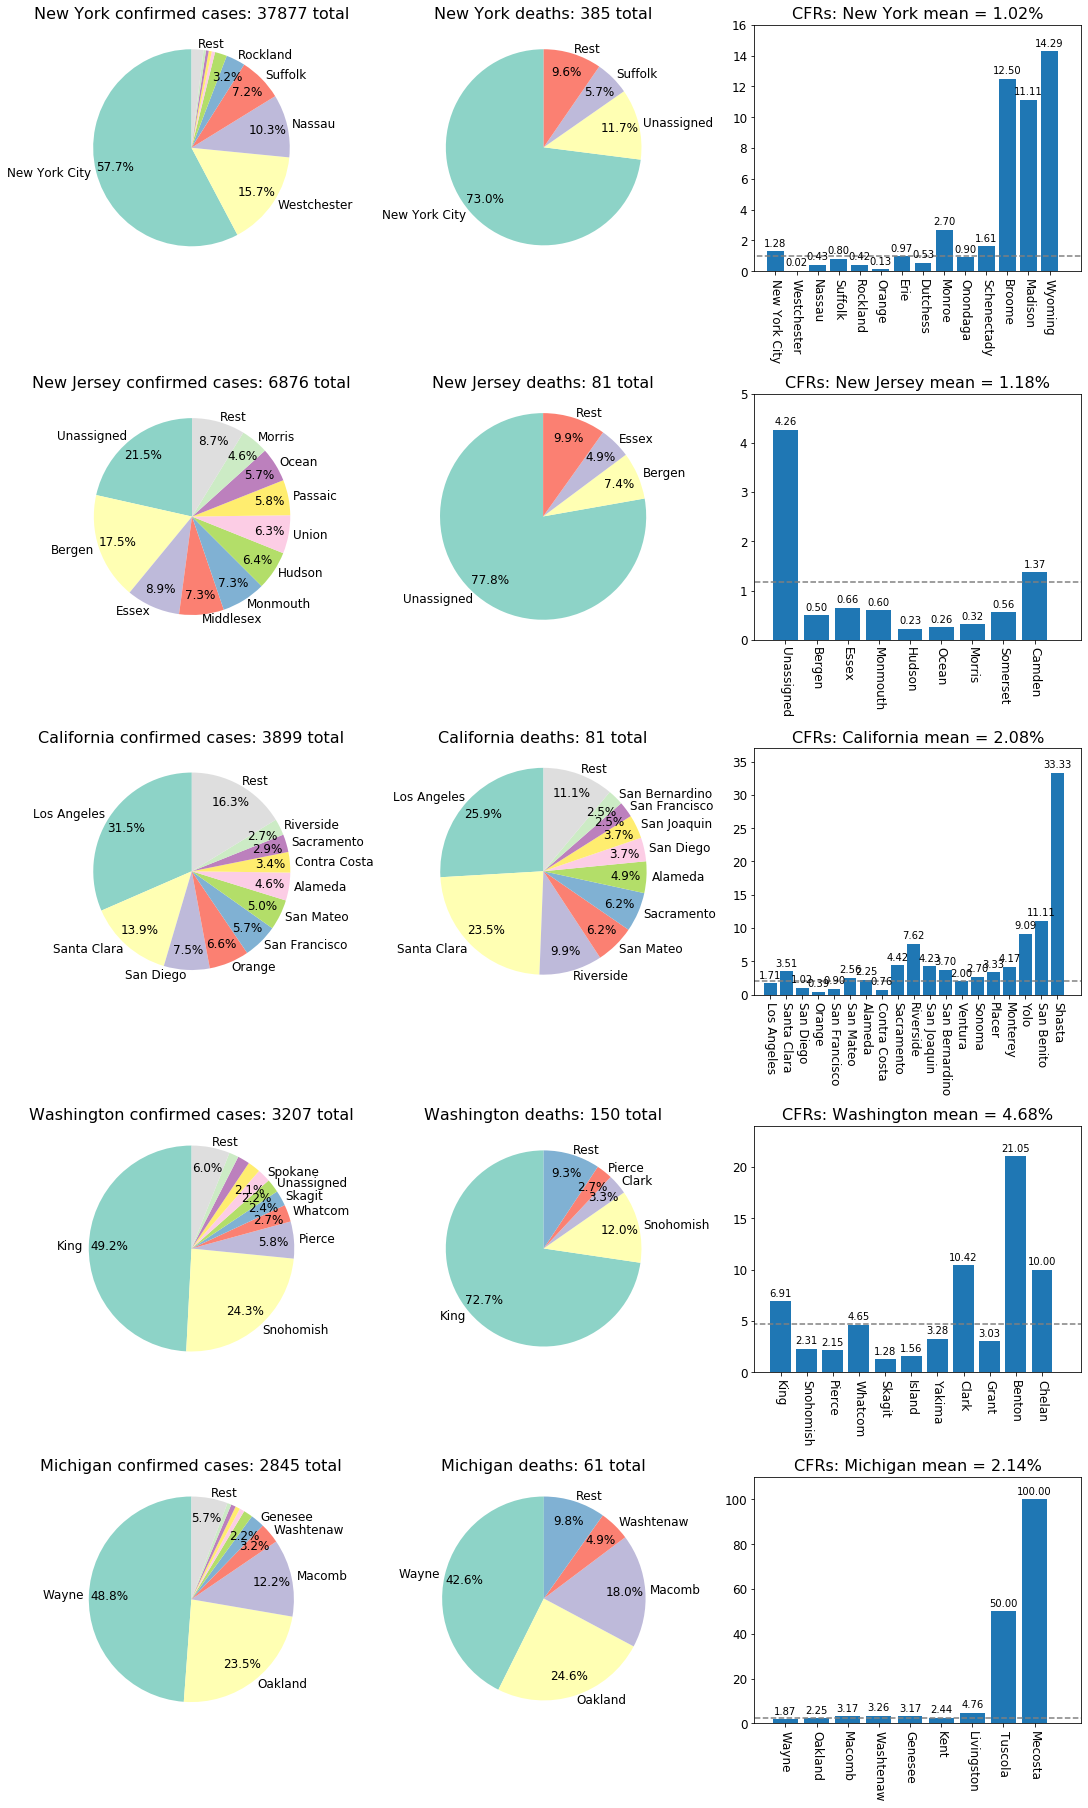

In [33]:
df_us_confirmed.sort_values(by = time_str[-1], inplace = True, ascending=False)
states = list(df_us_confirmed.index[0:5])

############ params ############
num_counties = 10

colors = pl.cm.Set3(np.linspace(0,1,11))
colors[7,:] = colors[10:]
colors[10,:] = 0.85

############ figure ############
fig = plt.figure(figsize = (15, 25), constrained_layout=True, facecolor="1")
gs = fig.add_gridspec(5, 7)

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title


for i, state in enumerate(states):
    df_state = df_today.groupby('Country_Region').get_group('US').groupby('Province_State').get_group(state).loc[:,['Admin2'] + cat_cols]
    df_state.set_index('Admin2', inplace = True)
    df_state = df_state.loc[(df_state!=0).any(axis=1)]
    df_state.loc[:,'CFR'] = df_state.Deaths/df_state.Confirmed*100
    df_state = df_state.replace([np.inf, -np.inf], 0)

    ############ total number pie chart ############
    ax = fig.add_subplot(gs[i,0:2])

    df_state.sort_values(by = 'Confirmed', inplace = True, ascending=False)
    percentages = []
    labels = []
    for county in list(df_state.index)[:num_counties]:
        percentages.append(df_state.loc[county, 'Confirmed']/np.sum(df_state.Confirmed)*100)
        if(percentages[-1] > 2):
            labels.append(county)
        else:
            labels.append('')
        if(sum(percentages) >= 99):
            break
    labels.append('Rest')
    percentages.append(100-sum(percentages))

    ax.pie(percentages, colors = colors,
           labels=labels, autopct = my_autopct, 
           pctdistance=0.8, labeldistance = 1.05,
           shadow=False, startangle=90,
           textprops = dict(size = 12))
    ax.axis('equal')
    ax.set_title(f"{state} confirmed cases: {np.sum(df_state.Confirmed):.0f} total")

    ############ total deaths pie chart ############
    ax = fig.add_subplot(gs[i,2:4])

    df_state.sort_values(by = 'Deaths', inplace = True, ascending=False)
    percentages = []
    labels = []
    for county in list(df_state.index)[:num_counties]:
        percentages.append(df_state.loc[county, 'Deaths']/np.sum(df_state.Deaths)*100)
        if(percentages[-1] > 2):
            labels.append(county)
        else:
            labels.append('')
        if(sum(percentages) >= 90):
            break
    labels.append('Rest')
    percentages.append(100-sum(percentages))

    ax.pie(percentages, colors = colors,
           labels=labels, autopct = my_autopct, 
           pctdistance=0.8, labeldistance = 1.05,
           shadow=False, startangle=90,
           textprops = dict(size = 12))
    ax.axis('equal')
    ax.set_title(f"{state} deaths: {np.sum(df_state.Deaths):.0f} total")

    ############ cfrs ############
    ax = fig.add_subplot(gs[i,4:])

    df_state.sort_values(by = 'Confirmed', inplace = True, ascending=False)
    y = df_state.CFR[df_state.CFR>0].to_numpy()
    x = np.arange(len(y))
    x1 = np.arange(-2, len(x)+2)
    fr_total = sum(df_state.Deaths)/sum(df_state.Confirmed)*100

    rects = ax.bar(x, y)
    ax.plot(x1, np.full(len(x1), fr_total), '--', color = 'grey')
    a = ax.set_xticks(x)
    a = ax.set_xticklabels(df_state[df_state.CFR>0].index)
    ax.tick_params(axis = 'x', labelrotation = -90)
    autolabel(rects, ax, '{:.2f}')
    ymax = np.ceil(np.max(y) + np.max(y)/10)
    ax.set_ylim([0, ymax])
    ax.set_xlim([-1, len(x) + 0.5])
    a = ax.set_title(f'CFRs: {state} mean = {fr_total:.2f}%')

In [34]:
"""bay area"""

'bay area'

In [35]:
bay_area_counties = ['Alameda', 'Contra Costa', 'Marin', 'Napa', 'San Francisco', 'San Mateo', 'Santa Clara', 'Solano', 'Sonoma']

df_state = df_today.groupby('Country_Region').get_group('US').groupby('Province_State').get_group('California').loc[:,['Admin2'] + cat_cols]
df_state.set_index('Admin2', inplace = True)
df_bay_area = df_state.loc[bay_area_counties,:]
df_bay_area.loc[:,'CFR'] = df_bay_area.Deaths/df_bay_area.Confirmed*100
df_bay_area = df_bay_area.replace([np.inf, -np.inf], 0)

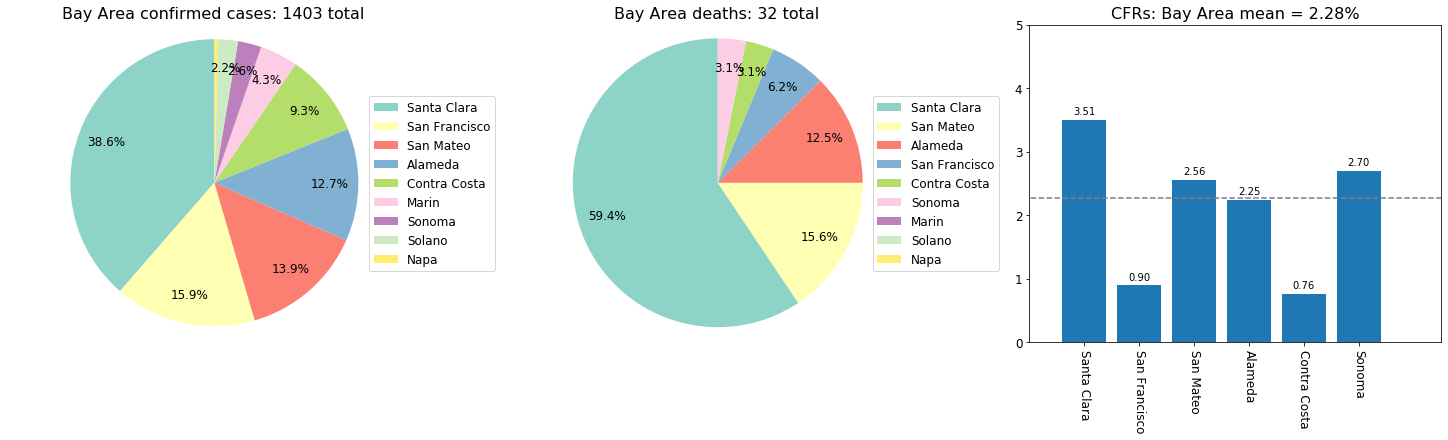

In [36]:
############ figure ############
fig = plt.figure(figsize = (20, 6), constrained_layout=True)
gs = fig.add_gridspec(1, 3)

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

############ total number pie chart ############
ax = fig.add_subplot(gs[0,0])

df_bay_area.sort_values(by = 'Confirmed', inplace = True, ascending=False)
percentages = []
labels = []
for county in df_bay_area.index:
    percentages.append(df_bay_area.loc[county, 'Confirmed']/np.sum(df_bay_area.Confirmed)*100)
    labels.append(county)

colors = pl.cm.Set3(np.linspace(0,1,len(labels)))
wedges, texts, autotexts = ax.pie(percentages, colors = colors, 
                                  autopct = my_autopct, pctdistance=0.8,
                                  shadow=False, startangle=90,
                                  textprops = dict(size = 12))

ax.legend(wedges, labels, loc="center right", bbox_to_anchor = (1, 0, 0.2, 1))
ax.axis('equal')
ax.set_title(f"Bay Area confirmed cases: {np.sum(df_bay_area.Confirmed):.0f} total")

############ total deaths pie chart ############
ax = fig.add_subplot(gs[0,1])

df_bay_area.sort_values(by = 'Deaths', inplace = True, ascending=False)
percentages = []
labels = []
for county in df_bay_area.index:
    percentages.append(df_bay_area.loc[county, 'Deaths']/np.sum(df_bay_area.Deaths)*100)
    labels.append(county)

colors = pl.cm.Set3(np.linspace(0,1,len(labels)))
wedges, texts, autotexts = ax.pie(percentages, colors = colors, 
                                  autopct = my_autopct, pctdistance=0.8,
                                  shadow=False, startangle=90,
                                  textprops = dict(size = 12))

ax.legend(wedges, labels, loc="center right", bbox_to_anchor = (1, 0, 0.2, 1))
ax.axis('equal')
ax.set_title(f"Bay Area deaths: {np.sum(df_bay_area.Deaths):.0f} total")

############ cfrs ############
ax = fig.add_subplot(gs[0,2])

df_bay_area.sort_values(by = 'Confirmed', inplace = True, ascending=False)
y = df_bay_area.CFR[df_bay_area.CFR>0].to_numpy()
x = np.arange(len(y))
x1 = np.arange(-2, len(x)+2)
fr_total = sum(df_bay_area.Deaths)/sum(df_bay_area.Confirmed)*100

rects = ax.bar(x, y)
ax.plot(x1, np.full(len(x1), fr_total), '--', color = 'grey')
a = ax.set_xticks(x)
a = ax.set_xticklabels(df_bay_area[df_bay_area.CFR>0].index)
ax.tick_params(axis = 'x', labelrotation = -90)
autolabel(rects, ax, '{:.2f}')
ymax = np.ceil(np.max(y) + 1)
ax.set_ylim([0, ymax])
ax.set_xlim([-1, len(x) + 0.5])
a = ax.set_title(f'CFRs: Bay Area mean = {fr_total:.2f}%')

In [37]:
""" World by country """

' World by country '

In [38]:
df_confirmed = df_time_series.groupby('Category').get_group('Confirmed').groupby('Country_Region').sum()[time_str]
df_recovered = df_time_series.groupby('Category').get_group('Recovered').groupby('Country_Region').sum()[time_str]
df_deaths = df_time_series.groupby('Category').get_group('Deaths').groupby('Country_Region').sum()[time_str]
df_active = df_confirmed - (df_recovered + df_deaths)
df_confirmed['New_Today'] = df_confirmed[time_str[-1]] - df_confirmed[time_str[-2]]

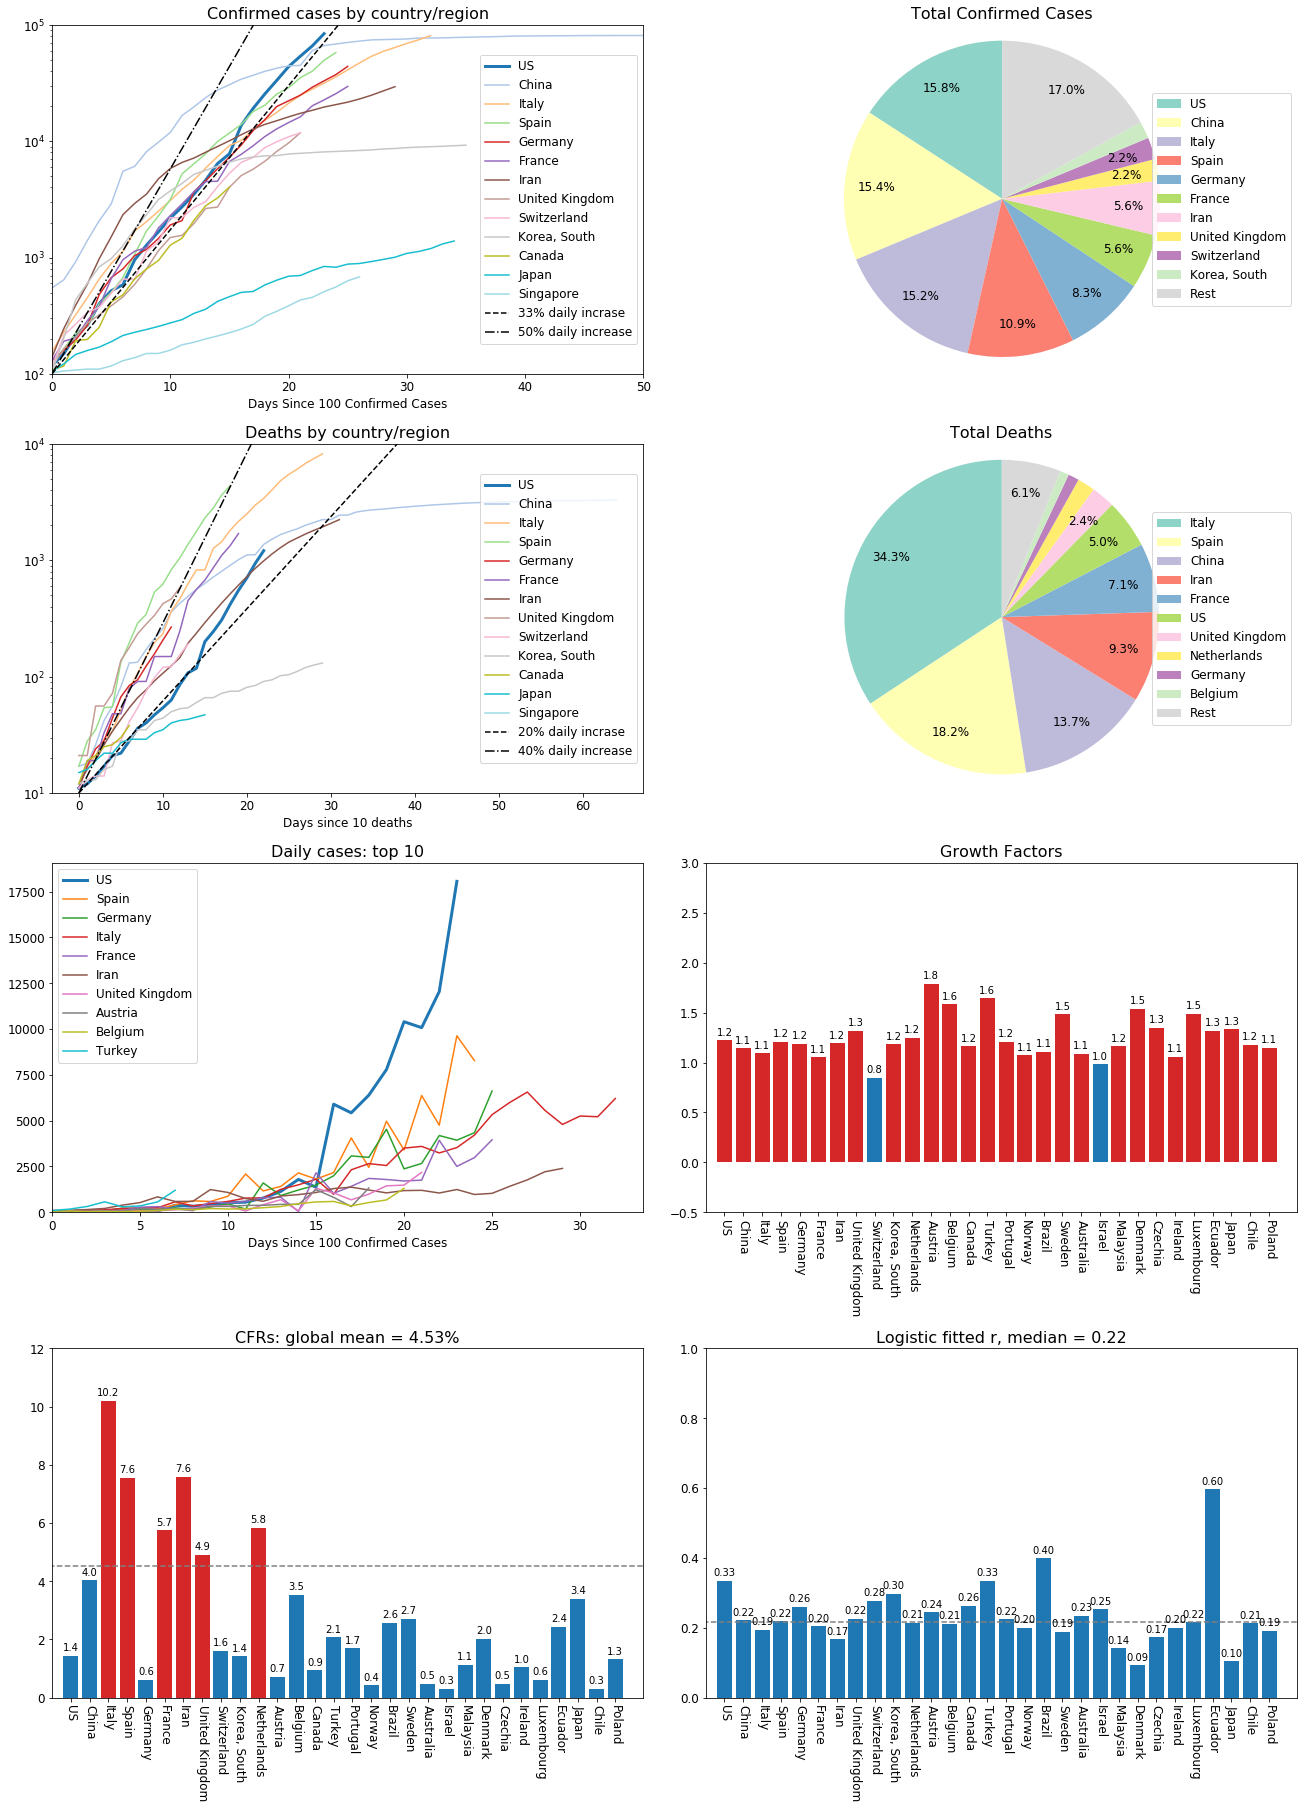

In [39]:
############ figure ############
fig = plt.figure(figsize = (18, 25), constrained_layout=True, facecolor="1")
gs = fig.add_gridspec(4, 2)

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title


########### r for logistic growth fit ############
ax6 = fig.add_subplot(gs[3, 1])

df_confirmed.sort_values(by = time_str[-1], inplace = True, ascending=False)
# countries = [ctry for ctry in df_confirmed.index if df_confirmed.loc[ctry,time_str[-1]] >= 500]
countries = list(df_confirmed.index[0:30])

x = np.arange(len(countries))
x1 = np.arange(-2, len(x)+2)
# if not 'rs_global' in locals():
rs_global = []
for i in x:
    ctry = countries[i]
    df_ctry = pd.DataFrame(df_confirmed.loc[ctry,time_plot])
    df_ctry = reshape_dataframe(df_ctry, time_plot)
    rs_global.append(get_growth_rate(df_ctry, time_plot))
rs_global = np.array(rs_global)

rects = ax6.bar(x[rs_global<1], rs_global[rs_global<1], color = 'tab:blue')
ax6.bar(x[rs_global>=1], rs_global[rs_global>=1], color = 'tab:blue')
ax6.plot(x1, np.full(len(x1), np.median(rs_global)), '--', color = 'grey')
a = ax6.set_xticks(x)
a = ax6.set_xticklabels(countries)
ax6.tick_params(axis = 'x', labelrotation = -90)
autolabel(rects, ax6, '{:.2f}')
ymax = np.ceil(np.max(y)) + 0.2
ax6.set_ylim([0, 1])
ax6.set_xlim([-1, len(x) + 0.5])
a = ax6.set_title(f'Logistic fitted r, median = {np.median(rs_global):.2f}')


############ total confirmed: normalize axis ############
ax2 = fig.add_subplot(gs[0, 0])

df_confirmed.sort_values(by = time_str[-1], inplace = True, ascending=False)
countries = list(df_confirmed.index[0:10])
countries += ['Canada','Japan', 'Singapore']

df_plot = df_confirmed.loc[countries,time_str]


colors = pl.cm.tab20(np.linspace(0,1,len(countries)))
max_x = 0
for i, ctr in enumerate(countries):
    xi = len(df_plot.loc[ctr, df_plot.loc[ctr,:]>100].to_numpy())
    if(xi > max_x):
        max_x = xi
    if(ctr == 'US'):
        ax2.plot(df_plot.loc[ctr, df_plot.loc[ctr,:]>100].to_numpy(), linewidth = 3, color = colors[i])
    else:
        ax2.plot(df_plot.loc[ctr, df_plot.loc[ctr,:]>100].to_numpy(), color = colors[i])

x = np.arange(max_x)
ax2.plot(x, 100 * (1+0.33) ** x, ls='--', color='k')
ax2.plot(x, 100 * (1+0.5) ** x, ls='-.', color='k')

ax2.set_ylim([100, 10**5])
ax2.set_xlim([0, 50])
ax2.legend(countries + 
           [f'33% daily incrase',
           f'50% daily increase'], 
           loc="center right") #bbox_to_anchor = (1, 0, 0.35, 1)
ax2.set_yscale('log')
ax2.set_xlabel('Days Since 100 Confirmed Cases')
ax2.set_title('Confirmed cases by country/region')

############ total confirmed: pie chart ############
ax = fig.add_subplot(gs[0,1])

df_confirmed.sort_values(by = time_str[-1], inplace = True, ascending=False)
percentages = []
labels = []
df_confirmed_total = np.sum(df_confirmed.loc[:,time_str[-1]])
for ctry in df_confirmed.index[0:10]:
    percentages.append(df_confirmed.loc[ctry, time_str[-1]]/df_confirmed_total*100)
    labels.append(ctry)
labels.append('Rest')
percentages.append(100-sum(percentages))

colors = pl.cm.Set3(np.linspace(0,1,11))
colors[7,:] = colors[10,:]
colors[10,:] = [0.85, 0.85, 0.85, 1]
wedges, texts, autotexts = ax.pie(percentages, colors = colors, 
                                  autopct = my_autopct, pctdistance=0.8,
                                  shadow=False, startangle=90,
                                  textprops = dict(size = 12))
ax.legend(wedges, labels, loc="center right", bbox_to_anchor = (1, 0, 0, 1))
ax.axis('equal')
ax.set_title("Total Confirmed Cases")


############ total deaths: normalized axis ############
ax1 = fig.add_subplot(gs[1, 0])

df_deaths.sort_values(by = time_str[-1], inplace = True, ascending=False)
countries = list(df_confirmed.index[0:10])
countries += ['Canada','Japan', 'Singapore']
df_plot = df_deaths.loc[countries,time_str]

colors = pl.cm.tab20(np.linspace(0,1,len(countries)))
max_x = 0
for i, ctr in enumerate(countries):
    xi = len(df_plot.loc[ctr, df_plot.loc[ctr,:]>10].to_numpy())
    if(xi > max_x):
        max_x = xi
    if(ctr == 'US'):
        ax1.plot(df_plot.loc[ctr,df_plot.loc[ctr,:]>10].to_numpy(), color = colors[i], linewidth = 3)
    else:
        ax1.plot(df_plot.loc[ctr,df_plot.loc[ctr,:]>10].to_numpy(), color = colors[i])

x = np.arange(max_x)
ax1.plot(x, 10 * (1+0.20) ** x, ls='--', color='k')
ax1.plot(x, 10 * (1+0.40) ** x, ls='-.', color='k')

ax1.set_ylim([10, 10**4])
ax1.legend(countries + 
           [f'20% daily incrase',
            f'40% daily increase'],
           loc="center right") #bbox_to_anchor = (1, 0, 0.35, 1)
ax1.set_yscale('log')
ax1.set_xlabel('Days since 10 deaths')
ax1.set_title('Deaths by country/region')


############ total deaths: pie chart ############
ax = fig.add_subplot(gs[1,1])

df_deaths.sort_values(by = time_str[-1], inplace = True, ascending=False)
percentages = []
labels = []
df_deaths_total = np.sum(df_deaths.loc[:,time_str[-1]])
for ctry in df_deaths.index[0:10]:
    percentages.append(df_deaths.loc[ctry, time_str[-1]]/df_deaths_total*100)
    labels.append(ctry)
labels.append('Rest')
percentages.append(100-sum(percentages))

colors = pl.cm.Set3(np.linspace(0,1,11))
colors[7,:] = colors[10,:]
colors[10,:] = [0.85, 0.85, 0.85, 1]
wedges, texts, autotexts = ax.pie(percentages, colors = colors, 
                                  autopct = my_autopct, pctdistance=0.8,
                                  shadow=False, startangle=90,
                                  textprops = dict(size = 12))
ax.legend(wedges, labels, loc="center right", bbox_to_anchor = (1, 0, 0, 1))
ax.axis('equal')
ax.set_title("Total Deaths")


############ daily cases ############
ax3 = fig.add_subplot(gs[2, 0])

df_confirmed.sort_values(by = 'New_Today', inplace = True, ascending=False)
countries = list(df_confirmed.index[0:10])

colors = pl.cm.tab10(np.linspace(0,1,len(countries)))
data_max = 0
for i, ctr in enumerate(countries):
    yi = df_confirmed.loc[ctr,time_str].transpose().diff().loc[df_confirmed.loc[ctr,time_str]>100].to_numpy()
    xi = np.arange(len(yi))
    if(np.max(yi) > data_max):
        data_max = np.max(yi)
    if(ctr == 'US'):
        ax3.plot(xi, yi, color = colors[i], linewidth = 3)
    else:
        ax3.plot(xi, yi, color = colors[i])

ax3.legend(countries, loc = 'upper left')
ax3.set_yscale('linear')
ax3.set_ylim([0, data_max + 1000])
a = ax3.set_title('Daily cases: top 10')
ax3.set_xlim(left = 0)
ax3.set_xlabel('Days Since 100 Confirmed Cases')

############ growth factors ############
ax4 = fig.add_subplot(gs[2, 1])

df_confirmed.sort_values(by = time_str[-1], inplace = True, ascending=False)
countries = list(df_confirmed.index[0:30])
# countries = [ctry for ctry in df_confirmed.index if df_confirmed.loc[ctry,time_str[-1]] >= 500]

df_gf = df_confirmed.loc[countries,time_str].transpose()
for ctry in countries:
    df_ctry = pd.DataFrame(df_confirmed.loc[ctry,time_str])
    df_ctry = reshape_dataframe(df_ctry, time_str)
    df_gf[ctry] = df_ctry.GF_rolling

x = np.arange(len(countries))
y = df_gf.loc[time_str[-1],:]

rects1 = ax4.bar(x[y<=1], y[y<=1], color = 'tab:blue')
rects2 = ax4.bar(x[y>1], y[y>1], color = 'tab:red')
a = ax4.set_xticks(x)
a = ax4.set_xticklabels(countries)
ax4.tick_params(axis = 'x', labelrotation = -90)
autolabel(rects1, ax4, '{:.1f}')
autolabel(rects2, ax4, '{:.1f}')
ymax = np.ceil(np.max(y)) + 1
ax4.set_ylim([-0.5, ymax])
a = ax4.set_title('Growth Factors')
ax4.set_xlim([-1, len(x) + 0.5])


############ fatality rate ############
ax5 = fig.add_subplot(gs[3, 0])

df_confirmed.sort_values(by = time_str[-1], inplace = True, ascending=False)
countries = list(df_confirmed.index[0:30])
# countries = [ctry for ctry in df_confirmed.index if df_confirmed.loc[ctry,time_str[-1]] >= 500]
fatal_rates = df_deaths.loc[countries,time_str] / df_confirmed.loc[countries,time_str] * 100
x = np.arange(len(countries))
x1 = np.arange(-2, len(x)+2)
fr_total = df_total.Fatality_rate[-1]
y = fatal_rates.loc[:,time_str[-1]]

rects1 = ax5.bar(x[y<=fr_total], y[y<=fr_total], color = 'tab:blue')
rects2 = ax5.bar(x[y>fr_total], y[y>fr_total], color = 'tab:red')
ax5.plot(x1, np.full(len(x1), fr_total), '--', color = 'grey')
a = ax5.set_xticks(x)
a = ax5.set_xticklabels(countries)
ax5.tick_params(axis = 'x', labelrotation = -90)
autolabel(rects1, ax5, '{:.1f}')
autolabel(rects2, ax5, '{:.1f}')
ymax = np.ceil(np.max(fatal_rates.loc[:,time_str[-1]]) + 1)
ax5.set_ylim([0, ymax])
ax5.set_xlim([-1, len(x) + 0.5])
a = ax5.set_title(f'CFRs: global mean = {fr_total:.2f}%')

In [40]:
""" China """

' China '

In [41]:
df_mc_confirmed = df_time_series.groupby('Country_Region').get_group('China').groupby('Category').get_group('Confirmed').groupby('Province_State').sum()[time_str]
df_mc_deaths = df_time_series.groupby('Country_Region').get_group('China').groupby('Category').get_group('Deaths').groupby('Province_State').sum()[time_str]

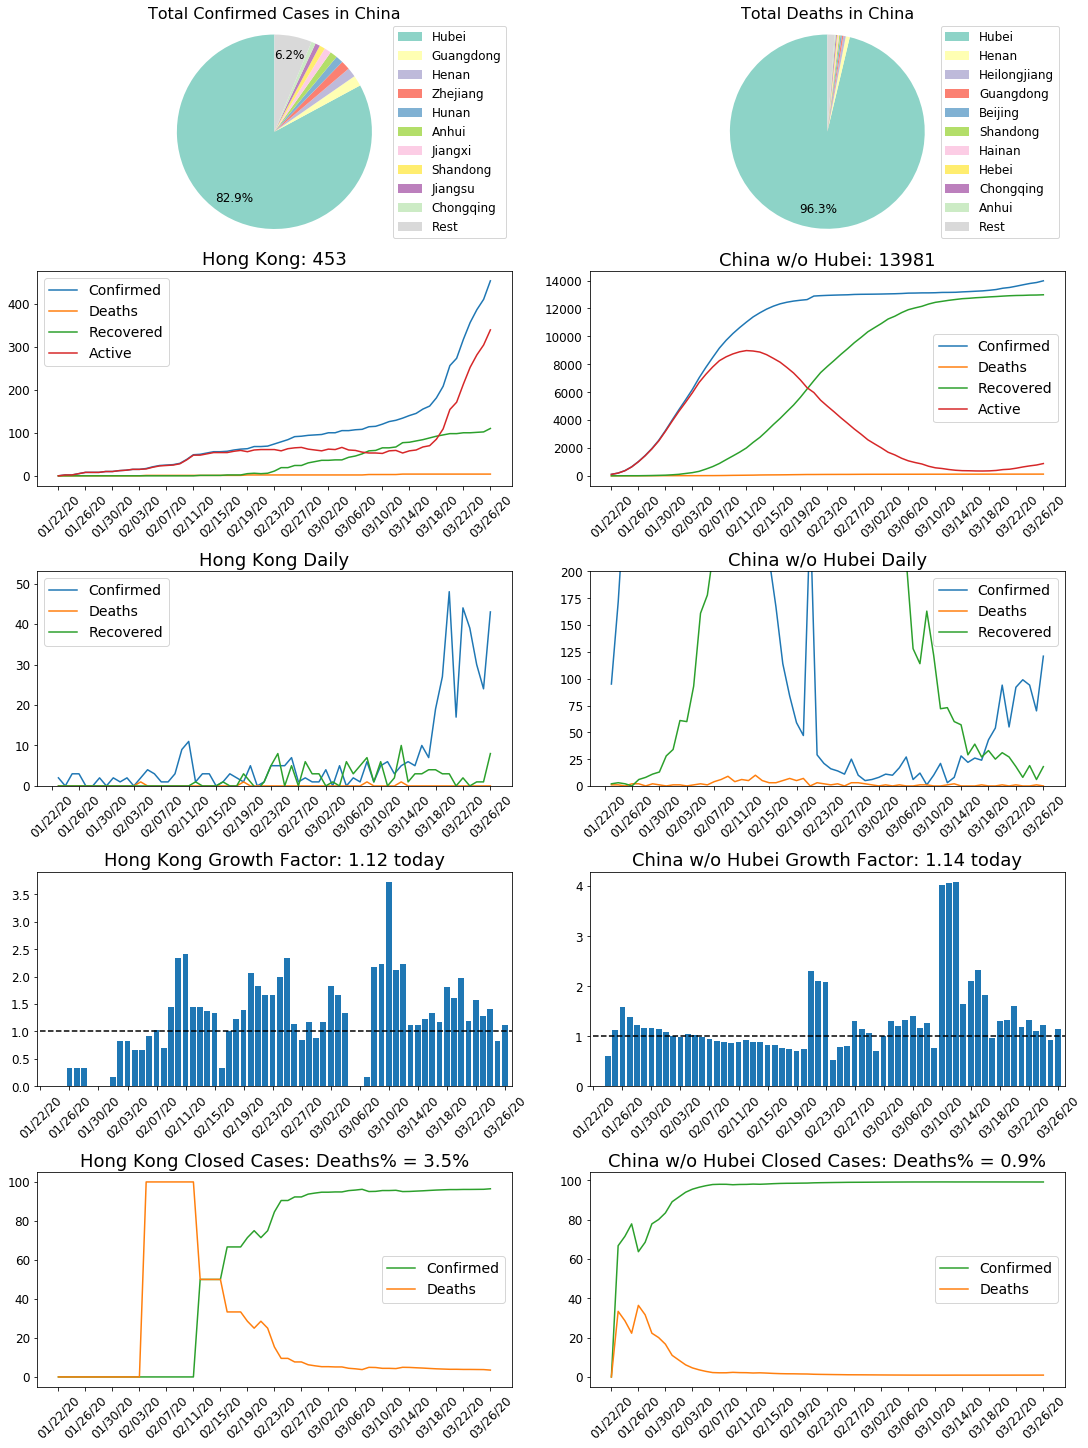

In [42]:
prov = 'Hong Kong'
df_prov = df_time_series.groupby('Country_Region').get_group('China').groupby('Province_State').get_group(prov).groupby('Category').sum().loc[:,time_str]
df_prov = reshape_dataframe(df_prov, time_str)

fig = plt.figure(figsize = (15, 20), constrained_layout=True, facecolor="1")
gs = fig.add_gridspec(5,2)

############ China confirmed pie chart
ax = fig.add_subplot(gs[0,0])

df_mc_confirmed.sort_values(by = time_str[-1], inplace = True, ascending=False)
percentages = []
labels = []
df_mc_confirmed_total = np.sum(df_mc_confirmed.loc[:,time_str[-1]])
for iprov in df_mc_confirmed.index[0:10]:
    percentages.append(df_mc_confirmed.loc[iprov, time_str[-1]]/df_mc_confirmed_total*100)
    labels.append(iprov)
labels.append('Rest')
percentages.append(100-sum(percentages))

colors = pl.cm.Set3(np.linspace(0,1,11))
colors[7,:] = colors[10,:]
colors[10,:] = [0.85, 0.85, 0.85, 1]

wedges, texts, autotexts = ax.pie(percentages, colors = colors, 
                                  autopct = my_autopct, pctdistance=0.8,
                                  shadow=False, startangle=90,
                                  textprops = dict(size = 12))
ax.legend(wedges, labels, loc="center right", bbox_to_anchor = (1, 0, 0, 1))
ax.axis('equal')
ax.set_title("Total Confirmed Cases in China")
              
############ China deaths pie chart
ax = fig.add_subplot(gs[0,1])

df_mc_deaths.sort_values(by = time_str[-1], inplace = True, ascending=False)
percentages = []
labels = []
df_mc_deaths_total = np.sum(df_mc_deaths.loc[:,time_str[-1]])
for iprov in df_mc_deaths.index[0:10]:
    percentages.append(df_mc_deaths.loc[iprov, time_str[-1]]/df_mc_deaths_total*100)
    labels.append(iprov)
labels.append('Rest')
percentages.append(100-sum(percentages))

colors = pl.cm.Set3(np.linspace(0,1,11))
colors[7,:] = colors[10,:]
colors[10,:] = [0.85, 0.85, 0.85, 1]

wedges, texts, autotexts = ax.pie(percentages, colors = colors, 
                                  autopct = my_autopct, pctdistance=0.8,
                                  shadow=False, startangle=90,
                                  textprops = dict(size = 12))
ax.legend(wedges, labels, loc="center right", bbox_to_anchor = (1, 0, 0, 1))
ax.axis('equal')
ax.set_title("Total Deaths in China")


############ prov total confirmed/death/recovered ############
ax1 = fig.add_subplot(gs[1, 0])
ax1.plot(df_prov[cat_cols])
myLocator = mticker.MultipleLocator(4)
ax1.xaxis.set_major_locator(myLocator)
ax1.tick_params(axis = 'x', labelrotation = 45)
ax1.legend(cat_cols, fontsize = 14)
ax1.set_title(f'{prov}: {int(df_prov.loc[time_str[-1], "Confirmed"])}', size = 18)

              
############ China w/o Hubei total confirmed/death/recovered ############
ax2 = fig.add_subplot(gs[1, 1])
ax2.plot(df_co[cat_cols])
myLocator = mticker.MultipleLocator(4)
ax2.xaxis.set_major_locator(myLocator)
ax2.tick_params(axis = 'x', labelrotation = 45)
ax2.legend(cat_cols, fontsize = 14)
ax2.set_title(f'China w/o Hubei: {int(df_co.loc[time_str[-1], "Confirmed"])}', size = 18)
              

############ Prov daily confirmed/death/recovered ############        
ax4 = fig.add_subplot(gs[2, 0])
ax4.plot(df_prov[cat_cols[:-1]].diff())
ax4.xaxis.set_major_formatter(mticker.FuncFormatter(format_fn))
myLocator = mticker.MultipleLocator(4)
ax4.xaxis.set_major_locator(myLocator)
ymax = np.max(df_prov[cat_cols[:-1]].diff().to_numpy()[1:,:].flatten())
ax4.set_ylim([0, min(ymax + 5, 300)])
ax4.tick_params(axis = 'x', labelrotation = 45)
ax4.legend(cat_cols[:-1], fontsize = 14)
ax4.set_title(f'{prov} Daily', size = 18)

############ China w/p Hubeo daily confirmed/death/recovered ############           
ax5 = fig.add_subplot(gs[2, 1])
ax5.plot(df_co[cat_cols[:-1]].diff())
ax5.xaxis.set_major_formatter(mticker.FuncFormatter(format_fn))
myLocator = mticker.MultipleLocator(4)
ax5.xaxis.set_major_locator(myLocator)
ax5.tick_params(axis = 'x', labelrotation = 45)
ax5.legend(cat_cols[:-1], fontsize = 14)
ax5.set_ylim([0, 200])
ax5.set_title('China w/o Hubei Daily', size = 18)

############ prov Growth Factor ############
ax6 = fig.add_subplot(gs[3, 0])
x = np.arange(0, len(time_str))
x1 = np.arange(0, len(time_str) + 2)

ax6.bar(x, df_prov.GF_rolling)
ax6.plot(x1, np.full(len(x1), 1), '--', color = 'k')
ax6.xaxis.set_major_formatter(mticker.FuncFormatter(format_fn))
myLocator = mticker.MultipleLocator(4)
ax6.xaxis.set_major_locator(myLocator)
ax6.set_xlim([-0.5, len(x)])
ax6.tick_params(axis = 'x', labelrotation = 45)
_ = ax6.set_title(f'{prov} Growth Factor: {df_prov.GF_rolling[-1]:.2f} today', size = 18)

              
############ China w/o Hubei Growth Factor ############
ax7 = fig.add_subplot(gs[3, 1])

ax7.bar(x, df_co.GF_rolling)
ax7.plot(x1, np.full(len(x1), 1), '--', color = 'k')
ax7.xaxis.set_major_formatter(mticker.FuncFormatter(format_fn))
myLocator = mticker.MultipleLocator(4)
ax7.xaxis.set_major_locator(myLocator)
ax7.set_xlim([-0.5, len(x)])
ax7.tick_params(axis = 'x', labelrotation = 45)
_ = ax7.set_title(f'China w/o Hubei Growth Factor: {df_co.GF_rolling[-1]:.2f} today', size = 18)

                    
############ prov Closed cases ############
ax8 = fig.add_subplot(gs[4, 0])
ax8.plot(df_prov.Recovered_prop, color = cat_color['Recovered'])
ax8.plot(df_prov.Death_prop, color = cat_color['Deaths'])
myLocator = mticker.MultipleLocator(4)
ax8.xaxis.set_major_locator(myLocator)
ax8.tick_params(axis = 'x', labelrotation = 45)
ax8.legend(cat_cols, fontsize = 14)
ax8.set_title(f'{prov} Closed Cases: Deaths% = {df_prov.Death_prop[-1]:.1f}%', size = 18)

############ China w/o Hubei Closed cases ############
ax9 = fig.add_subplot(gs[4, 1])
ax9.plot(df_co.Recovered_prop, color = cat_color['Recovered'])
ax9.plot(df_co.Death_prop, color = cat_color['Deaths'])
myLocator = mticker.MultipleLocator(4)
ax9.xaxis.set_major_locator(myLocator)
ax9.tick_params(axis = 'x', labelrotation = 45)
ax9.legend(cat_cols, fontsize = 14)
_ = ax9.set_title(f'China w/o Hubei Closed Cases: Deaths% = {df_co.Death_prop[-1]:.1f}%', size = 18)

In [43]:
x = np.arange(len(time_str))
y1 = df_hb.Confirmed.to_list()
y2 = df_co.Confirmed.to_list()
y3 = df_hb.Deaths.to_list()
y4 = df_co.Deaths.to_list()

ind_t0 = 48
t = np.arange(len(time_str))[:ind_t0]
pt = y2[:ind_t0]

# popt_exp, pcov_exp = opt.curve_fit(exp_growth,  t,  p_t)
popt1, pcov1 = opt.curve_fit(logistic_growth,  x,  y1, maxfev=10000)
# popt1, pcov1 = opt.curve_fit(logistic_growth,  t,  pt, p0 = [0.1, 100, 1], maxfev=10000)
popt2, pcov2 = opt.curve_fit(logistic_growth,  t,  pt, maxfev=10000)
popt3, pcov3 = opt.curve_fit(logistic_growth,  x,  y3, maxfev=10000)
popt4, pcov4 = opt.curve_fit(logistic_growth,  x,  y4, maxfev=10000)

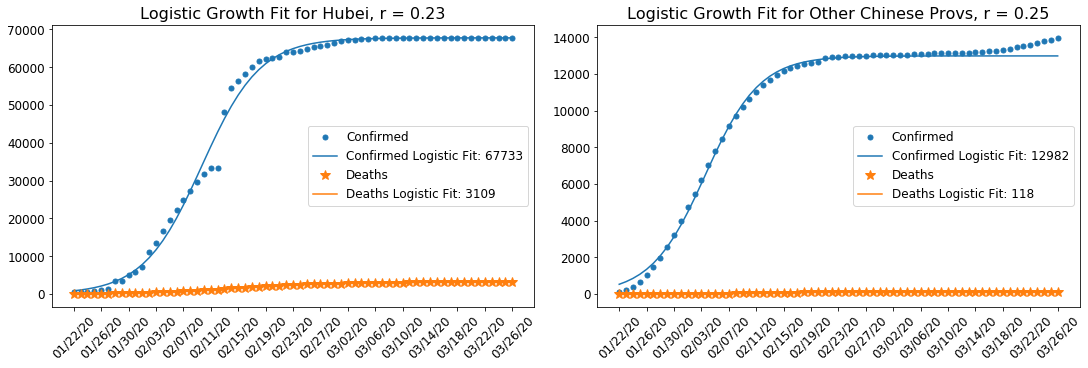

In [44]:
future = 0

x1 = np.arange(len(x) + future)

fig = plt.figure(figsize = (15, 5), constrained_layout=True)
gs = fig.add_gridspec(1, 2)

ax1 = fig.add_subplot(gs[0, 0])
plt.plot(x, y1, '.', ms = 10, color = cat_color['Confirmed'])
plt.plot(x1, logistic_growth(x1, popt1[0], popt1[1], popt1[2]), '-', color = cat_color['Confirmed'])
c1_end = logistic_growth(x1, popt1[0], popt1[1], popt1[2])[-1]
plt.plot(x, y3, '*', ms = 10, color = cat_color['Deaths'])
plt.plot(x1, logistic_growth(x1, popt3[0], popt3[1], popt3[2]), '-', color = cat_color['Deaths'])
d1_end = logistic_growth(x1, popt3[0], popt3[1], popt3[2])[-1]

plt.title(f'Logistic Growth Fit for Hubei, r = {popt1[0]:.2f}')
ax1.xaxis.set_major_formatter(mticker.FuncFormatter(format_fn))
myLocator = mticker.MultipleLocator(4)
ax1.xaxis.set_major_locator(myLocator)
ax1.tick_params(axis = 'x', labelrotation = 45)
# _ = ax1.set_xlim(right = len(time_str))
ax1.legend(['Confirmed', 
            f'Confirmed Logistic Fit: {c1_end:.0f}', 
            'Deaths', 
            f'Deaths Logistic Fit: {d1_end:.0f}'])


ax2 = fig.add_subplot(gs[0, 1])
plt.plot(x, y2, '.', ms = 10, color = cat_color['Confirmed'])
plt.plot(x1, logistic_growth(x1, popt2[0], popt2[1], popt2[2]), '-', color = cat_color['Confirmed'])
c2_end = logistic_growth(x1, popt2[0], popt2[1], popt2[2])[-1]
plt.plot(x, y4, '*', ms = 10, color = cat_color['Deaths'])
plt.plot(x1, logistic_growth(x1, popt4[0], popt4[1], popt4[2]), '-', color = cat_color['Deaths'])
d2_end = logistic_growth(x1, popt4[0], popt4[1], popt4[2])[-1]

plt.title(f'Logistic Growth Fit for Other Chinese Provs, r = {popt2[0]:.2f}')
ax2.xaxis.set_major_formatter(mticker.FuncFormatter(format_fn))
myLocator = mticker.MultipleLocator(4)
ax2.xaxis.set_major_locator(myLocator)
ax2.tick_params(axis = 'x', labelrotation = 45)
ax2.legend(['Confirmed', 
            f'Confirmed Logistic Fit: {c2_end:.0f}', 
            'Deaths', 
            f'Deaths Logistic Fit: {d2_end:.0f}'])
# _ = ax2.set_xlim(right = len(time_str))

In [45]:
### world bar graph

In [46]:
df_confirmed.sort_values(by = time_str[-1], inplace = True, ascending=False)
df_recovered.sort_values(by = time_str[-1], inplace = True, ascending=False)
df_deaths.sort_values(by = time_str[-1], inplace = True, ascending=False)

In [47]:
# recovered = df_recovered.loc[:,time_str[-1]].to_numpy()
# deaths = df_deaths.loc[:,time_str[-1]].to_numpy()
# confirmed = df_confirmed.loc[:,time_str[-1]].to_numpy()
# x = np.arange(len(confirmed))

# fig, ax = plt.subplots(1,1,figsize = (40,6))
# rects = ax.bar(x, confirmed)
# plt.bar(x, deaths)
# plt.bar(x, recovered, bottom = deaths)

# plt.legend(['Confirmed', 'Recovered', 'Deaths'])
# plt.yscale('log')
# plt.ylim(bottom = 10**-0.1)
# plt.xlim([-1, len(x)])
# a = ax.set_xticks(x)
# a = ax.set_xticklabels(list(df_confirmed.index))
# a = plt.xticks(rotation=-90)
# a = plt.title(f'Total {len(df_confirmed.index)-4} Countries affected', fontsize = 18)
# autolabel(rects, ax, '{:.0f}')

In [48]:
""" Specific Country/Region"""

' Specific Country/Region'

In [53]:
region = 'Taiwan*'
future = 0

In [54]:
### prepare dataframe
df_region = pd.concat([df_confirmed.loc[region,time_str], 
                     df_deaths.loc[region,time_str],
                     df_recovered.loc[region,time_str]],
                    axis = 1)
df_region.columns = cat_cols[:3]
df_region = df_region.transpose()
df_region = reshape_dataframe(df_region, time_str)

### data fitting
x = np.arange(len(time_str))
y1 = df_region.Confirmed.to_list()
y2 = df_region.Deaths.to_list()

res = df_region[df_region.GF_rolling_thr != 0.0].bfill(axis=1).index[0]
ind_t0 = max(0, time_str.index(res)-3)
t = np.arange(len(time_str))[ind_t0:]- ind_t0
pt1 = y1[ind_t0:]
pt2 = y2[ind_t0:]

popt_exp1, pcov_exp1 = opt.curve_fit(exp_growth,  t,  pt1, maxfev = 10000)
popt_log1, pcov_log1 = opt.curve_fit(logistic_growth,  t,  pt1, p0 = (0.1, 100, 1), maxfev=10000)
popt_exp2, pcov_exp2 = opt.curve_fit(exp_growth,  t,  pt2, maxfev = 10000)
popt_log2, pcov_log2 = opt.curve_fit(logistic_growth,  t,  pt2, p0 = (0.1, 100, 1), maxfev=10000)

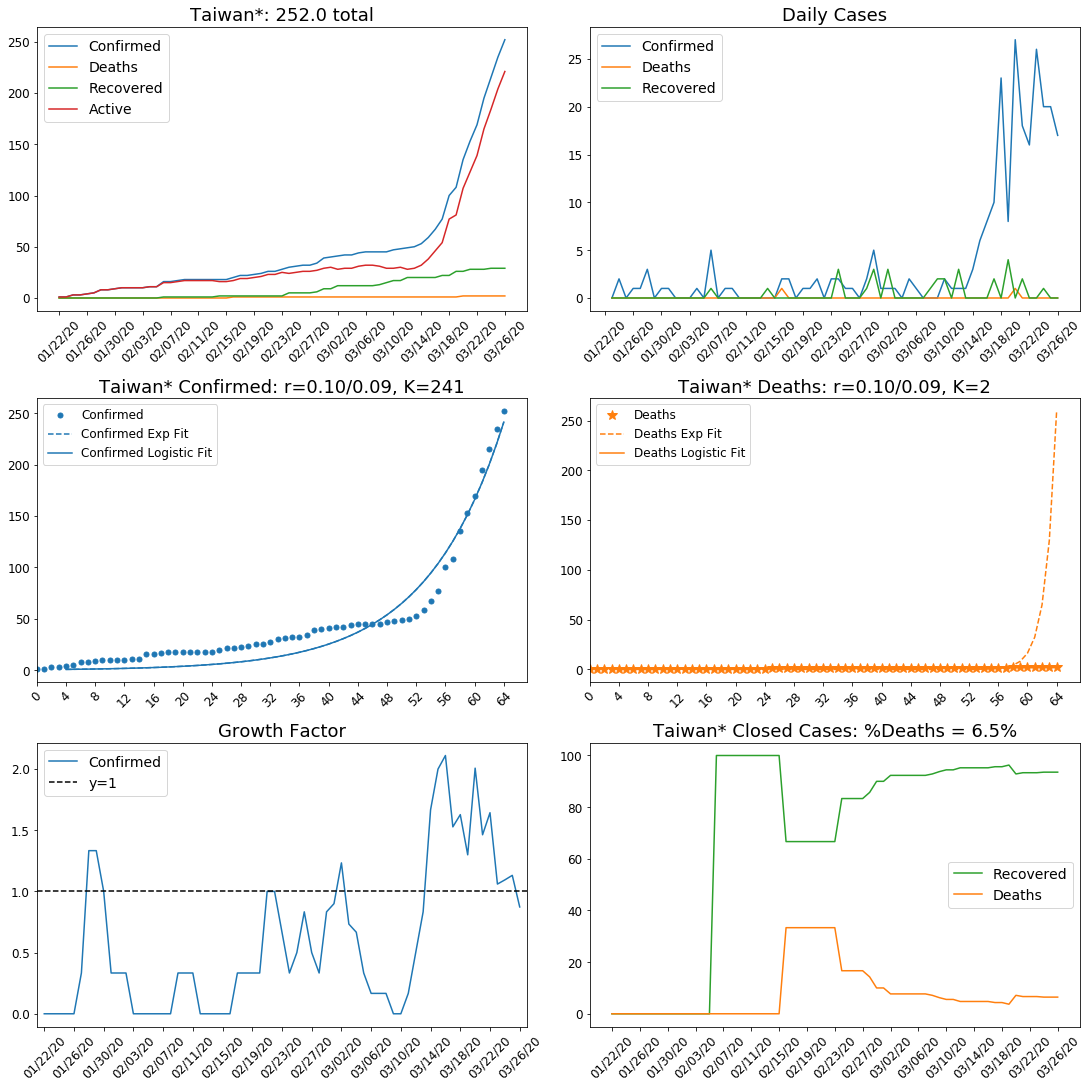

In [60]:
fig = plt.figure(figsize = (15, 15), constrained_layout=True, facecolor="1")
gs = fig.add_gridspec(3,2)

######### time series plot #########
ax1 = fig.add_subplot(gs[0, 0])
ax1.plot(df_region.loc[:, cat_cols])
myLocator = mticker.MultipleLocator(4)
ax1.xaxis.set_major_locator(myLocator)
ax1.tick_params(axis = 'x', labelrotation = 45)
ax1.legend(cat_cols, fontsize = 14)
ax1.set_title(f'{ctry}: {df_confirmed.loc[ctry, time_str[-1]]} total', size = 18)

######### daily cases #########
ax5 = fig.add_subplot(gs[0, 1])
ax5.plot(df_region.loc[:,cat_cols[:-1]].diff())
ax5.xaxis.set_major_formatter(mticker.FuncFormatter(format_fn))
myLocator = mticker.MultipleLocator(4)
ax5.xaxis.set_major_locator(myLocator)
ax5.tick_params(axis = 'x', labelrotation = 45)
ax5.legend(cat_cols, fontsize = 14)
ax5.set_title('Daily Cases', size = 18)


######### confirmed fitting plot #########
ax2 = fig.add_subplot(gs[1, 0])
x = np.arange(len(time_str))
x1 = np.arange(len(t) + future)

ax2.plot(x, y1, '.', ms = 10, color = cat_color['Confirmed'])
if(future == 0):
    ax2.plot(x1 + ind_t0, exp_growth(x1, popt_exp1[0], popt_exp1[1]), '--', color = cat_color['Confirmed'])
ax2.plot(x1 + ind_t0, logistic_growth(x1, popt_log1[0], popt_log1[1], popt_log1[2]), '-', color = cat_color['Confirmed'])
confirm_end = logistic_growth(x1, popt_log1[0], popt_log1[1], popt_log1[2])[-1]

if(future == 0):
    ax2.legend(['Confirmed', 
                'Confirmed Exp Fit', 
                'Confirmed Logistic Fit'])
    ax2.set_title(f'{ctry}: r={popt_exp1[0]:.2f}/{popt_log1[0]:.2f}', fontsize = 18)
else:
    ax2.legend(['Confirmed', 
                f'Confirmed Logistic Fit'])
ax2.set_title(f'{ctry} Confirmed: r={popt_exp1[0]:.2f}/{popt_log1[0]:.2f}, K={confirm_end:.0f}', fontsize = 18)
myLocator = mticker.MultipleLocator(4)
ax2.xaxis.set_major_locator(myLocator)
ax2.tick_params(axis = 'x', labelrotation = 45)
ax2.set_xlim(left = 0)


######### deaths fitting plot #########
ax2 = fig.add_subplot(gs[1, 1])
ax2.plot(x, y2, '*', ms = 10, color = cat_color['Deaths'])
if(future == 0):
    ax2.plot(x1 + ind_t0, exp_growth(x1, popt_exp2[0], popt_exp2[1]), '--', color = cat_color['Deaths'])
ax2.plot(x1 + ind_t0, logistic_growth(x1, popt_log2[0], popt_log2[1], popt_log2[2]), color = cat_color['Deaths'])
death_end = logistic_growth(x1, popt_log2[0], popt_log2[1], popt_log2[2])[-1]
ax2.set_yscale('linear')

if(future == 0):
    ax2.legend(['Deaths', 
                'Deaths Exp Fit', 
                'Deaths Logistic Fit'])
    ax2.set_title(f'{ctry}: r{popt_exp1[0]:.2f}/{popt_log1[0]:.2f}', fontsize = 18)
else:
    ax2.legend(['Deaths', 
                f'Deaths Logistic Fit'])
ax2.set_title(f'{ctry} Deaths: r={popt_exp1[0]:.2f}/{popt_log1[0]:.2f}, K={death_end:.0f}', fontsize = 18)
myLocator = mticker.MultipleLocator(4)
ax2.xaxis.set_major_locator(myLocator)
ax2.tick_params(axis = 'x', labelrotation = 45)
ax2.set_xlim(left = 0)


######### growth factor #########
ax3 = fig.add_subplot(gs[2, 0])
x = np.arange(-1, len(time_str)+2)
ax3.plot(df_region.GF_rolling)
ax3.plot(x, np.full(len(x), 1), '--', color = 'k')
ax3.xaxis.set_major_formatter(mticker.FuncFormatter(format_fn))
myLocator = mticker.MultipleLocator(4)
ax3.xaxis.set_major_locator(myLocator)
ax3.tick_params(axis = 'x', labelrotation = 45)
ax3.legend(['Confirmed', 'y=1'], fontsize = 14)
ax3.set_title('Growth Factor', size = 18)
ax3.set_xlim([-1, len(time_str)])

######### closed cases #########
ax8 = fig.add_subplot(gs[2, 1])
ax8.plot(df_region.Recovered_prop, color = cat_color['Recovered'])
ax8.plot(df_region.Death_prop, color = cat_color['Deaths'])
myLocator = mticker.MultipleLocator(4)
ax8.xaxis.set_major_locator(myLocator)
ax8.tick_params(axis = 'x', labelrotation = 45)
ax8.legend(['Recovered', 'Deaths'], fontsize = 14)
_ = ax8.set_title(f'{ctry} Closed Cases: %Deaths = {df_region.Death_prop[-1]:.1f}%', size = 18)

In [ ]:
"""Archive Land"""

In [ ]:
# colors = pl.cm.tab10(np.linspace(0,1,len(countries)))
# for i, ctr in enumerate(countries):
#     ax4.plot(df_gf[ctr], color = colors[i])
# x = np.arange(-1, len(time_str)+2)
# ax4.plot(x, np.full(len(x), 1), '--', color = 'k')

# ax4.legend(countries, loc = 'upper left')
# ax4.set_yscale('linear')
# ax4.set_ylim([0, 5])
# a = ax4.set_title('Growth Factors: top 10 countries with most new cases')
# ax4.xaxis.set_major_formatter(mticker.FuncFormatter(format_fn))
# myLocator = mticker.MultipleLocator(4)
# ax4.xaxis.set_major_locator(myLocator)
# ax4.set_xlim(left = -1, right = len(time_str))
# ax4.tick_params(axis = 'x', labelrotation = 45)

# growth_factors = (df_confirmed.loc[countries, time_str[2:]].to_numpy() - df_confirmed.loc[countries, time_str[1:-1]].to_numpy()) \
# /(df_confirmed.loc[countries, time_str[1:-1]].to_numpy() - df_confirmed.loc[countries, time_str[:-2]].to_numpy())
# y = (growth_factors[:,-1] + growth_factors[:,-2])/2
# y[~np.isfinite(y)] = 0
# y = df_gf.loc[time_str[-1],:]

# # rects = ax5.bar(x[y<=1], y[y<=1], color = 'tab:blue')
# # rects = ax5.bar(x[y>1], y[y>1], color = 'tab:red')

# a = ax5.set_xticks(x)
# a = ax5.set_xticklabels(countries)
# ax5.tick_params(axis = 'x', labelrotation = -90)
# autolabel(rects, ax5, '{:.2f}')
# ymax = np.ceil(np.max(y)) + 1
# ax5.set_ylim([0, ymax])
# a = ax5.set_title('Growth Factor of places w/ >100 confirmed cases')

In [ ]:
# if(today not in time_str):
#     print('New Data from CSSE! Update time_series_covid19.csv now!')
#     gps_today = list(df_today.groupby(['Country_Region', 'Province_State']).groups.keys())
#     gps_ts = list(df_time_series.groupby(['Country_Region', 'Province_State']).groups.keys())
#     for igp, gp in enumerate(gps_today):
#         if(igp%30 == 0):
#             print(igp)
#         if(gp not in gps_ts):
#             print(gp)
#             df_new = pd.DataFrame(columns = df_time_series.columns)
#             for i, cat in enumerate(cat_cols[:-1]):
#                 df_new.loc[i,'Country_Region'] = gp[0]
#                 df_new.loc[i,'Province_State'] = gp[1]
#                 df_new.loc[i, time_str] = 0
#                 df_new.loc[i, today] = df_today.groupby(['Country_Region', 'Province_State']).get_group(gp).loc[:,cat].to_list()[0]
#                 df_new.loc[i, 'Category'] = cat
#             df_time_series = df_time_series.append(df_new, ignore_index = True)
#         else:
#             for cat in cat_cols[:-1]:
#                 i = df_time_series[(df_time_series.Country_Region == gp[0]) 
#                    * (df_time_series.Province_State == gp[1]) 
#                    * (df_time_series.Category == cat)].index
#                 df_time_series.loc[i,today] = df_today.groupby(['Country_Region', 'Province_State']).get_group(gp).loc[:,cat].to_list()[0]
#     time_str, time_datetime = get_time_columns(df_time_series.columns)
#     time_str = sorted(time_str)
#     cols_ordered = ['Province_State', 'Country_Region', 'Category'] + time_str
#     df_time_series = df_time_series.reindex(cols_ordered, axis=1)
# #     df_time_series.to_csv(os.path.join(path_time_series, 'time_series_covid19.csv'), index = False)
# #     print('New spreadsheet saved!')
# else:
#     print(f'Data up to date! Today = {today}')

In [ ]:
# path_time_series = os.path.join(master_path, 'csse_covid_19_data', 'csse_covid_19_time_series')
# path_daily = os.path.join(master_path, 'csse_covid_19_data', 'csse_covid_19_daily_reports')
# today_csv = '03-23-2020.csv'
# today = '3/23/20'
# folders, files = parse_folder_info(path_time_series)
# df_time_series = pd.DataFrame()
# # df_time_series_reorged = pd.DataFrame(columns = ['Country/Region', 'Province/State', 'Date', 'Category', 'Number'])
# for file_name in files:
#     if('.csv' in file_name and '-covid-' in file_name):
#         df_current = pd.read_csv(os.path.join(path_time_series, file_name))        
#         category = file_name[21:file_name.index('.csv')]
#         print(category)
#         df_current.loc[:,'Category'] = category
#         if df_time_series.empty:
#             df_time_series = df_current
#         else:
#             df_time_series = df_time_series.append(df_current, ignore_index = True)
# time_str, time_datetime = get_time_columns(df_time_series.columns)
# # df_today = pd.read_csv(os.path.join(path_daily, today_csv))

# df_time_series.loc[df_time_series.loc[:,'Province/State'].isna(),'Province/State'] = 'N/A'
# # df_today.loc[df_today.loc[:,'Province/State'].isna(), 'Province/State'] = 'N/A'
# # df_time_series.loc[:,'New Today'] = df_time_series.loc[:,time_str[-1]] - df_time_series.loc[:,time_str[-2]]

### fix 3/12/20 datapoints
# alt_cols = ['3/12/20', '3/15/20']
# df_alteration = pd.read_csv(os.path.join(master_path, 'time_series_covid19_alteration.csv'))
# df_alteration.set_index('Country/Region', inplace = True)
# for ctry in df_alteration.index:
#     ind = (df_time_series['Category'] == 'Confirmed') & (df_time_series['Country/Region'] == ctry)
#     if(np.sum(ind) > 1):
#         ind = ind & (df_time_series['Province/State'] == ctry)
#     for col in alt_cols:
#         if not pd.isna(df_alteration.loc[ctry, col]):
#             df_time_series.loc[ind, col] = df_alteration.loc[ctry, col]

### total number
# ax1 = fig.add_subplot(gs[0, 0])

# df_confirmed.sort_values(by = time_str[-1], inplace = True, ascending=False)
# countries = list(df_confirmed.index[0:15])
# df_plot = df_confirmed.loc[countries,time_str]

# colors = pl.cm.tab20(np.linspace(0,1,len(countries)))
# for i, ctr in enumerate(countries):
#     if(ctr == 'US'):
#         ax1.plot(df_plot.loc[ctr,:], color = colors[i], linewidth = 3)
#     else:
#         ax1.plot(df_plot.loc[ctr,:], color = colors[i])

# ax1.legend(countries)
# ax1.set_yscale('linear')
# # plt.ylim(top = 2000)
# ax1.set_title('Total number of cases: top 15')
# myLocator = mticker.MultipleLocator(4)
# ax1.xaxis.set_major_locator(myLocator)
# ax1.tick_params(axis = 'x', labelrotation = 45)


In [ ]:
### Daily new cases              
# ax3 = fig.add_subplot(gs[1, :])
# # hubei_daily = hubei.loc['Confirmed',:].to_numpy()[1:] - hubei.loc['Confirmed',:].to_numpy()[:-1]
# # co_daily = china_others.loc['Confirmed',:].to_numpy()[1:] - china_others.loc['Confirmed',:].to_numpy()[0:-1]
# x = np.arange(len(time_str))
# width = 0.35
# rects1 = ax3.bar(x - width/2, df_prov.Daily, width = width)
# rects2 = ax3.bar(x + width/2, df_co.Daily, width = width)
# # ax3.set_yscale('log')
# ax3.set_yscale('linear')
# ax3.set_ylim([0, 200])
# a = ax3.set_xticks(x)
# a = ax3.set_xticklabels(time_str[1:])
# ax3.tick_params(axis = 'x', labelrotation = 45)
# ax3.legend([prov, 'China w/o Hubei'], fontsize = 14)
# ax3.set_ylim(bottom = 10**-0.1)
# ax3.set_title('Daily Cases', size = 18)


### Wish List:
- Time Series for US and state testing